<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2024/blob/main/Module%201/7_SymbolicRegression_Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PySR

In [1]:
'''
# Install Julia
!wget https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz
!tar -xvzf julia-1.6.1-linux-x86_64.tar.gz
!mv julia-1.6.1 /opt/
!ln -s /opt/julia-1.6.1/bin/julia /usr/local/bin/julia

# Test Julia installation
!julia -e 'using InteractiveUtils; versioninfo()'

# Install IJulia to get the Julia Kernel
!julia -e 'import Pkg; Pkg.add("IJulia")'
'''

'\n# Install Julia\n!wget https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz\n!tar -xvzf julia-1.6.1-linux-x86_64.tar.gz\n!mv julia-1.6.1 /opt/\n!ln -s /opt/julia-1.6.1/bin/julia /usr/local/bin/julia\n\n# Test Julia installation\n!julia -e \'using InteractiveUtils; versioninfo()\'\n\n# Install IJulia to get the Julia Kernel\n!julia -e \'import Pkg; Pkg.add("IJulia")\'\n'

In [2]:
!pip install pysr #==0.16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.4 MB/s eta 0:00:00


In [3]:
import pysr
# pysr.install()

[juliapkg] Locating Julia ^1.6.1
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.1 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to have Julia
[juliapkg]   installed in multiple locations. It is recommended to install JuliaUp
[juliapkg]   (https://github.com/JuliaLang/juliaup) or Julia (https://julialang.org/downloads)
[juliapkg]   yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.1-linux-x86_64.tar.gz
             download complete
[juliapkg] Verifying download
[juliapkg] Installing Julia 1.10.1 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install
[juliapkg] Using Julia 1.10.1 at /root/.julia/environments/pyjuliapkg/pyjuliapkg/install/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing pac

# Regression-optimization

The code from: https://towardsdatascience.com/optimization-with-surrogate-models-via-symbolic-regression-38f9b7536a36

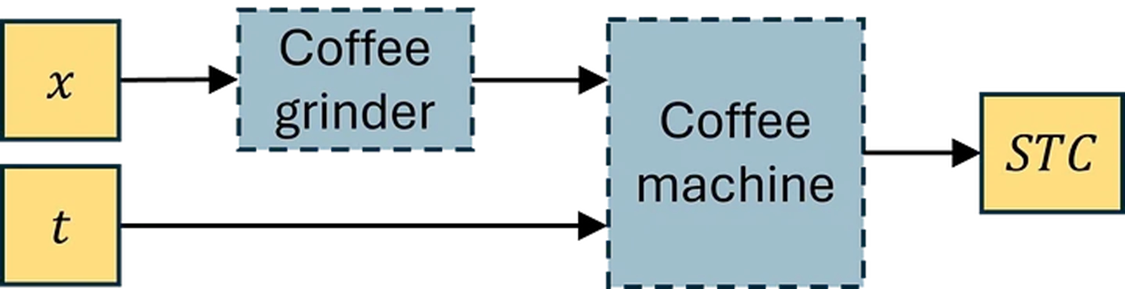

In [4]:
# Get the bounds of the data
xbounds = [0.05, 1] # mm
tbounds = [5, 60]   # seconds

# Get some samples [x,t]=[particle size, brewing time]
samples = [[0.05, 10], [0.05, 50], [0.09, 15], [0.2, 25], [0.3, 35], [0.3, 45], [0.5, 15], [1, 55], [0.6, 55], [0.8, 15], [0.95, 10], [0.8, 30]]

In [5]:
# Design the scaling function
def scale(x_, bounds_):
    return (x_ - bounds_[0])/(bounds_[1] - bounds_[0])

# Scale the data
samples = [[scale(samples[i][0], xbounds), scale(samples[i][1], tbounds)] for i in range(len(samples))]

# Store old bounds and scale the new bounds
xbounds_old = xbounds
tbounds_old = tbounds
xbounds = [scale(xbounds[0], xbounds), scale(xbounds[1], xbounds)]
tbounds = [scale(tbounds[0], tbounds), scale(tbounds[1], tbounds)]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Some settings for the plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [5,4]
fontsize_text = 12
fontsize_ticks = 9
DPI = 250
makevideo = True
video_angle_veocity = 4 # degrees per frame

# Define the ground truth function
def ground_truth_STC(x_,t_):
    xshift = np.mean(xbounds)
    tshift = np.mean(tbounds)
    return np.exp(-(x_ - xshift)**2 - (t_ - tshift)**2)

# Get the meshgrid for plotting
X, T = np.meshgrid(np.linspace(xbounds[0], xbounds[1], 100), np.linspace(tbounds[0], tbounds[1], 100))
STC = ground_truth_STC(X, T)

# Get a give number of samples from the ground truth function
x = [samples[i][0] for i in range(len(samples))]
t = [samples[i][1] for i in range(len(samples))]
STC_samples = ground_truth_STC(x, t)

GIF saved!


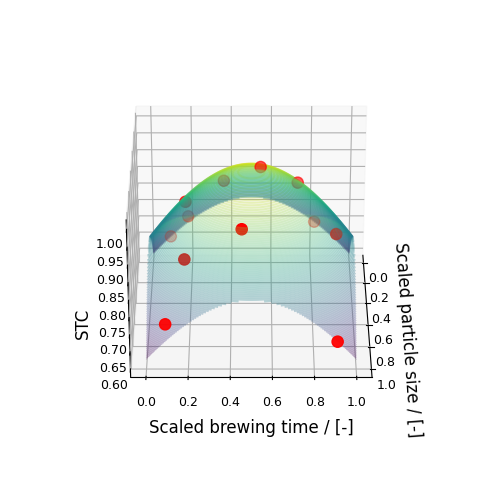

In [7]:
# Plot the ground truth function with our sample data
figname = 'Figure_2a'
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
ax.contour(X, T, STC, 100, alpha=0.3)
ax.scatter(x, t, STC_samples, s=65, c='r')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_zlabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.zaxis.set_tick_params(labelsize=fontsize_ticks)
ax.set_box_aspect(aspect=None, zoom=0.78)
plt.tight_layout()

# Make a video
if makevideo:
    # Save figure normally
    # plt.savefig(f'./{figname}.png', dpi=DPI)
    # Rotate figure and save frames
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        ax.view_init(30, angle)
        # plt.draw() # Only needed in non-interactive mode (.py file)
        # plt.pause(.001) # Only needed in non-interactive mode (.py file)
        plt.savefig(f'./{figname}_{angle}.png', dpi=DPI)
    frames = []
    import imageio
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        image = imageio.v2.imread(f'./{figname}_{angle}.png')
        frames.append(image)
    imageio.mimsave(f'.{figname}_gif.gif', # output gif
                    frames,          # array of input frames
                    fps = 5)         # optional: frames per second
    print('GIF saved!')
else:
    plt.savefig(f'./{figname}.png', dpi=DPI)
    plt.show()

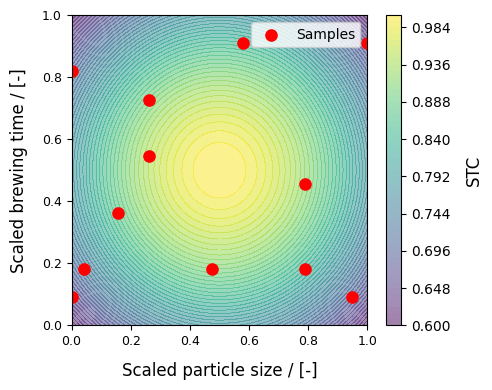

In [8]:
figname = 'Figure_2b'
fig = plt.figure()
ax = fig.gca()
CM=ax.contourf(X, T, STC, 100, alpha=0.5, levels=50, linestyles='solid')
cbar = fig.colorbar(CM)
cbar.ax.set_ylabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.scatter(x, t, s=65, c='r', label='Samples')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.legend()
plt.tight_layout()
plt.savefig(f'./{figname}.png', dpi=DPI)

In [9]:
inputs = np.array([x, t]).T
outputs = np.array(STC_samples)
print(f'[+] Shape of inputs: {inputs.shape}')
print(f'[+] Shape of outputs: {outputs.shape}')

[+] Shape of inputs: (12, 2)
[+] Shape of outputs: (12,)


In [10]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-"], unary_operators=["square", "exp"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:857: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(


In [11]:
model.fit(inputs, outputs)

Compiling Julia backend...


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.080e+05
Head worker occupation: 1.6%
Progress: 58 / 1500 total iterations (3.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.226e-01  1.594e+01  y = x₁
2           1.063e-02  3.042e+00  y = square(exp(-0.10879))
4           1.059e-02  2.112e-03  y = ((0.021874 * x₁) - -0.79453)
5           9.999e-03  5.726e-02  y = ((-0.071028 * square(x₀)) - -0.82737)
6           1.841e-03  1.692e+00  y = ((x₀ * (0.95843 - x₀)) - -0.70315)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.590e+05
Head worker occupation: 1.7%
Progress: 192 / 1500 total iterations (12.800%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss   

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                                 x1   
	1         3.041610e+00                           square(exp(-0.10879131))   
	2         2.111941e-03                    ((0.02187445 * x1) - -0.794531)   
	3         5.725954e-02          ((square(x0) * -0.07102714) - -0.8273711)   
	4         1.691991e+00              (((0.958412 - x0) * x0) - -0.7031557)   
	5         3.128855e-03    ((-1.0423228 * square(x0)) - (-0.6984143 - x0))   
	6         7.974303e-04  (((0.9867838 - (x0 * 1.0294726)) * x0) - -0.70...   
	7         1.090416e-07  (((((0.9585205 - x0) * x0) * 1.029491) - -0.72...   
	8         8.318765e-01  (((x1 - -0.5305004) - (square(x0) - x0)) - squ...   
	9         2.509178e-03  ((((0.99538475 - x1) * x1) - square(x0)) - (-0...   
	10  >>>>  2.267238e+01  exp(((x1 - 0.5000004) - ((x0 * x0) - x0)) - sq...   
	
	            loss  complexity  
	0   2.226494e-01           1  
	1   1.063328e-02           2  
	2   1.058846e-02           4  
	3   9.999200e-03           5  
	4   1.841378e-03           6  
	5   1.835626e-03           7  
	6   1.834162e-03           8  
	7   1.834162e-03           9  
	8   7.982857e-04          10  
	9   7.962852e-04          11  
	10  1.133908e-13          12  
]

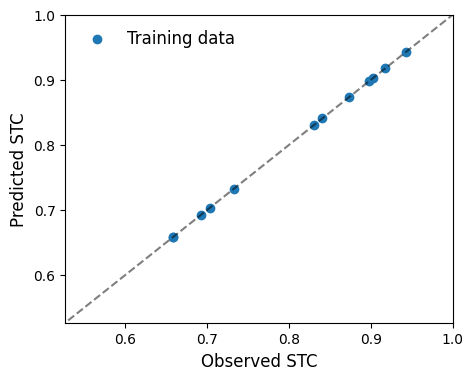

In [12]:
figname = 'Figure_3'
plt.figure()
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.scatter(outputs, model.predict(inputs), label='Training data')
plt.xlabel('Observed STC', fontsize=fontsize_text)
plt.ylabel('Predicted STC', fontsize=fontsize_text)
plt.xlim([np.min(outputs)*0.8, 1])
plt.ylim([np.min(outputs)*0.8, 1])
plt.legend(fontsize=12, frameon=False)
plt.savefig(f'./{figname}.png', dpi=DPI)
plt.show()

In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs, model.predict(inputs))
print(f'[+] Best identified model (LaTeX): {model.latex()}')
print(f'[+] R2 score: {r2}')

[+] Best identified model (LaTeX): 0.607 e^{- x_{0}^{2} + x_{0} - x_{1}^{2} + x_{1}}
[+] R2 score: 0.9999999999901018


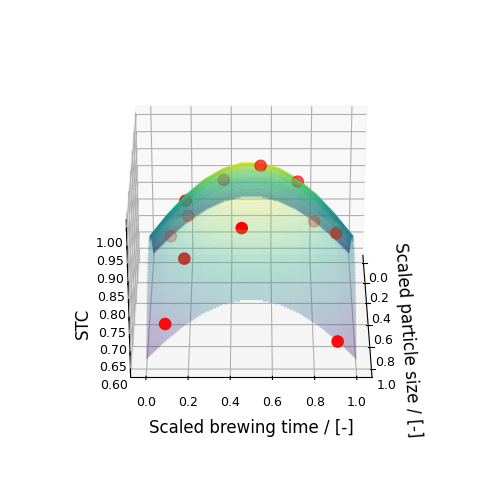

In [14]:
# Get a meshgrid for the samples (smaller than above)
X, T = np.meshgrid(np.linspace(xbounds[0], xbounds[1], len(x)), np.linspace(tbounds[0], tbounds[1], len(t)))
STCpred = np.zeros([len(x), len(t)])

# Extract each
for i in range(len(x)):
    for j in range(len(t)):
        datapoint = np.array([X[i,j], T[i,j]]).reshape(1,-1)
        STCpred[i,j] = model.predict(X=datapoint)[0]

# Plot
figname = 'Figure_4'
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
ax.contour(X, T, STCpred, 100, alpha=0.3)
ax.scatter(x, t, STC_samples, s=65, c='r')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_zlabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.zaxis.set_tick_params(labelsize=fontsize_ticks)
ax.set_box_aspect(aspect=None, zoom=0.78)
plt.tight_layout()

# Make a video
if makevideo:
    # Save figure normally
    plt.savefig(f'./{figname}.png', dpi=DPI)
    # Rotate figure and save frames
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        ax.view_init(30, angle)
        # plt.draw() # Only needed in non-interactive mode (.py file)
        # plt.pause(.001) # Only needed in non-interactive mode (.py file)
        plt.savefig(f'./{figname}_{angle}.png', dpi=DPI)
    frames = []
    import imageio
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        image = imageio.v2.imread(f'./{figname}_{angle}.png')
        frames.append(image)
    imageio.mimsave(f'./{figname}_gif.gif', # output gif
                    frames,          # array of input frames
                    fps = 5)         # optional: frames per second
else:
    plt.savefig(f'./{figname}.png', dpi=DPI)
    plt.show()

# (Optional) Exploring square and triangle Ising models

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm
from typing import Union, Dict, Callable

import math
import time

In [16]:
#@title Square Ising Model

class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

In [17]:
#@title Triangular Ising model
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


class Tri_IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2 : 2D triangular lattice
    - J_mat: (numpy matrix of shape(3,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
              or: (list) of size(3,5) with each element belonging to scipy distribution from which to draw J value (for bond disorder)
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750, prop = 0.5):
    self.N = N
    self.prop = prop
    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if (J_mat).all == None:
      J_mat = np.zeros((3,5))
      J_mat[0,1] = J_mat[0,3] = J_mat[1,0] = J_mat[1,4] = J_mat[2,1] = J_mat[2,3] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat
    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState()
    self.T = T

  def initialState(self):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1
    Can do better, remove probability and see how you can include numbers'''

    state = np.random.choice([1, -1], size = ([self.N,2*self.N]), p=[self.prop, 1-self.prop])

    for i in range(0,self.N,2):
      for j in range(0,2*self.N,2):
        state[i,j] = 0

    for i in range(1,self.N,2):
      for j in range(1,2*self.N,2):
        state[i,j] = 0


    return state

  def EmptySite(self, row_1, col_1, spin_1, config):
    #You can do better, this takes a lot of time because of intermittent zeros
    row_2, col_2 = row_1, col_1
    spin_2 = spin_1
    while (spin_2*spin_1 != -1.0):
        row_2, col_2     = np.random.randint(0, self.N), np.random.randint(0, 2*self.N)
        spin_2 = config[row_2, col_2]

    return row_2, col_2

  def mcmove(self):
    '''Monte Carlo move using Metropolis algorithm '''
    M = 3 #check whether you can obtain this from J_mat
    T = 5
    beta = 1.0/self.T
    config = self.config
    config_1 = np.where(config == -1, 0.0, config)

    for i in range(self.N):
      for j in range(2*self.N):
        row_1, col_1 = np.random.randint(0, self.N), np.random.randint(0, 2*self.N)
        spin_1 = config[row_1, col_1]

        if(spin_1):
          J_mat = self.J_mat
          row_2, col_2 = np.random.randint(0, self.N), np.random.randint(0, 2*self.N)
          spin_2   = config[row_2, col_2]

          if (spin_2*spin_1 != -1.0):
            (row_2, col_2) = self.EmptySite(row_1, col_1, spin_1, config)
            spin_2 = config[row_2, col_2]

          ini_ene_1, ini_ene_2, fin_ene_1, fin_ene_2 = 0.0,0.0,0.0,0.0

          if spin_1 == 1.0:
              for p in range(-int(M/2), int(M/2)+1, 1):
                for q in range(-int(T/2), int(T/2)+1, 1):
                  ini_ene_1 += -J_mat[int(M/2)+p, int(T/2)+q] * config[(row_1+p)%self.N,(col_1+q)%(2*self.N)] * spin_1
                  ini_ene_2 += -J_mat[int(M/2)+p, int(T/2)+q] * config_1[(row_2+p)%self.N,(col_2+q)%(2*self.N)] * spin_2
                  fin_ene_1 += -J_mat[int(M/2)+p, int(T/2)+q] * config_1[(row_1+p)%self.N,(col_1+q)%(2*self.N)] * spin_2
                  fin_ene_2 += -J_mat[int(M/2)+p, int(T/2)+q] * config[(row_2+p)%self.N,(col_2+q)%(2*self.N)] * spin_1

          if spin_1 == -1.0:
              for p in range(-int(M/2), int(M/2)+1, 1):
                for q in range(-int(T/2), int(T/2)+1, 1):
                  ini_ene_1 += -J_mat[int(M/2)+p, int(T/2)+q] * config_1[(row_1+p)%self.N,(col_1+q)%(2*self.N)] * spin_1
                  ini_ene_2 += -J_mat[int(M/2)+p, int(T/2)+q] * config[(row_2+p)%self.N,(col_2+q)%(2*self.N)] * spin_2
                  fin_ene_1 += -J_mat[int(M/2)+p, int(T/2)+q] * config[(row_1+p)%self.N,(col_1+q)%(2*self.N)] * spin_2
                  fin_ene_2 += -J_mat[int(M/2)+p, int(T/2)+q] * config_1[(row_2+p)%self.N,(col_2+q)%(2*self.N)] * spin_1

          cost = (fin_ene_1 + fin_ene_2) - (ini_ene_1 + ini_ene_2)
          if cost < 0 or (rand() < np.exp(-cost*beta)):
            spin_1 *= -1
            spin_2 *= -1
          config[row_1, col_1], config[row_2, col_2] = spin_1, spin_2

      self.config = config
    return None


  def calcEnergy(self):
    '''Returns the energy of the current configuration'''
    config = self.config
    config_1 = np.where(config == -1, 0.0, config)
    M = 3
    T = 5
    energy = 0.0
    for i in range(self.N):
      for j in range(2*self.N):

        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        if (s):
            if s == 1.0:
                for p in range(-int(M/2), int(M/2)+1, 1):
                    for q in range(-int(T/2), int(T/2)+1, 1):
                        energy += -J_mat[int(M/2)+p, int(T/2)+q] * config[(i+p)%self.N,(j+q)%(2*self.N)] * config[i,j]

            if s == -1.0:
                for p in range(-int(M/2), int(M/2)+1, 1):
                    for q in range(-int(T/2), int(T/2)+1, 1):
                        energy += -J_mat[int(M/2)+p, int(T/2)+q] * config_1[(i+p)%self.N,(j+q)%(2*self.N)] * config[i,j]
    return energy/4.0


  def calcMag(self):
    '''Magnetization of a given configuration'''
    return float(np.nansum(self.config))

  def calcAbsMag(self):
    ''' Absolute Magnetization of a given configuration'''
    return float(np.abs(np.nansum(self.config)))

  def performIsingSim(self):

    E1, E2 = 0.0,0.0   #These are all the average properties of all MC steps used
    E_traj = np.zeros(self.mcSteps)
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,2*self.N])   #Saving all the configurations

    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        self.mcmove()

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        self.mcmove()
        Ene = self.calcEnergy()
        E_traj[j] = Ene/(self.N*self.N)


        E1 = E1 + Ene
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = self.config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)




    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy,
      'SpecificHeat': SpecificHeat,
      'E_traj': E_traj}
    else:
      results_dict = {'Energy': Energy, 'E_traj': E_traj,
      'SpecificHeat': SpecificHeat,
    }

    self.results = results_dict

  def plot_config(self, config, figsize = (7,7)):

    config_nozeros = np.zeros([self.N,self.N])
    k = 0
    for i in range(0,self.N):
      if i%2 == 0:
        for j in range(1,2*self.N,2):
            config_nozeros[np.unravel_index(k, config_nozeros.shape)] = config[i,j]
            k+=1
      else:
        for j in range(0,2*self.N,2):
            config_nozeros[np.unravel_index(k, config_nozeros.shape)] = config[i,j]
            k+=1

    x = np.linspace(0, 1, self.N)
    y = np.linspace(1, 0, self.N)
    X, Y = np.meshgrid(x, y)

    dx = np.diff(x)[0]
    dy = np.diff(y)[0]
    ds = np.sqrt(dx**2 +  dy**2)

    # example_data = np.random.choice([-1,1], size = (nx,ny))
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [-1,0,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    patches = []
    for i in x:
        for n, j in enumerate(y):
            if n%2:
                polygon = mpatches.RegularPolygon([i-dx/2., j], 6, 0.6*dx)
            else:
                polygon = mpatches.RegularPolygon([i, j], numVertices = 6, radius = 0.6*dx)
            patches.append(polygon)

    collection = PatchCollection(patches, cmap=cmap, norm=norm, alpha=1.0)

    fig, ax = plt.subplots(1,1, figsize = figsize)
    ax.add_collection(collection)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    collection.set_array(np.transpose(config_nozeros).ravel())

Full grid evaluation for 20x20 1D Ising model - Square Model

Recommended parameters:
- 20x20 field
- 500 steps for equilibration
- 500 steps for computation


---Performing Equlibration---



100%|██████████| 50/50 [00:01<00:00, 36.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:02<00:00, 20.80it/s]


Completed. Saving


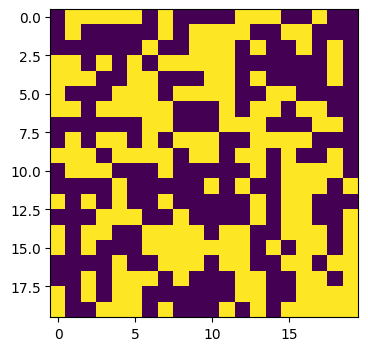

In [18]:
results_dict = {}
approx_ys = np.zeros(1)
time_eval = np.zeros(1)

J_mat = np.array([[0,0,0,0,0],
                  [0,0,1,0,0],
                  [0,1,0,1,0],
                  [0,0,1,0,0],
                  [0,0,0,0,0]])

start_time = time.time()

np.random.seed(0)
sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 12.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
sq_sim.performIsingSim()   # Running the sim
end_time = time.time()
time_eval = end_time-start_time

results_dict[0] = {'sim': sq_sim.results,}
approx_ys[0] = results_dict[0]['sim']['SpecificHeat']
plt.imshow(results_dict[0]['sim']['config'][-1])
plt.show()

Full grid evaluation for 20x20 1D Ising model - Triangular Model

Recommended parameters:
- 20x20 field
- 500 steps for equilibration
- 500 steps for computation


---Performing Equlibration---



100%|██████████| 150/150 [00:10<00:00, 14.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 150/150 [00:10<00:00, 14.09it/s]
<ipython-input-17-d3cc8f309220>:231: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([i-dx/2., j], 6, 0.6*dx)


Completed. Saving


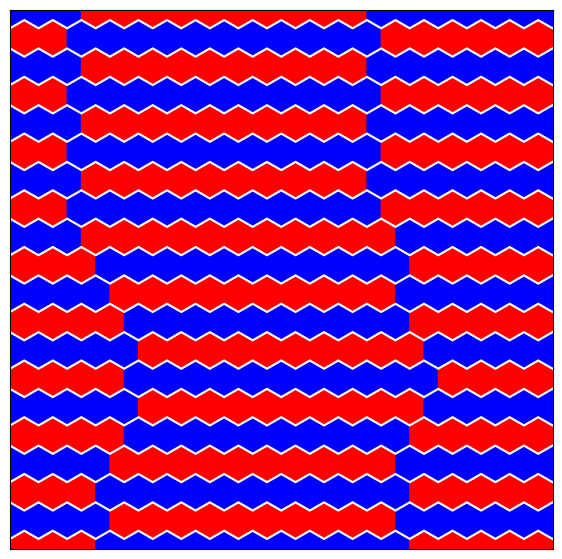

In [19]:
results_dict_tri = {}
approx_ys_tri = np.zeros(1)
time_eval = np.zeros(1)

J_mat = np.array([[0,-1,0,-1,0],
                  [1,0,0,0,1],
                  [0,-1,0,-1,0]])

np.random.seed(0)
tri_sim = Tri_IsingSim(N = 20, J_mat = J_mat, T = 0.2, save_trajectories=True, # Intializing the object
                       eqSteps = 150, mcSteps = 150,
                       prop = 0.5)  # Proportion of the sites occupied

tri_sim.performIsingSim()   # Running the sim

results_dict_tri[0] = {'sim': tri_sim.results,}
approx_ys_tri[0] = results_dict_tri[0]['sim']['SpecificHeat']
tri_sim.plot_config(results_dict_tri[0]['sim']['config'][-1])
plt.show()

# PySr on Square Ising Model

Using Symbolic Regression in PySR package by Miles Cranmer to explore Ising model.

- The original PySR paper is: https://arxiv.org/pdf/2305.01582.pdf
- The PySR GitHub repository is: https://github.com/MilesCranmer/PySR
- The excellent docs for PySR are: https://astroautomata.com/PySR/

- The Ising model is by Rama Vasudevan, vasudevanrk@ornl.gov
- This model has been used in several of our publications, including https://pubs.aip.org/aip/jap/article/128/16/164304/568362/Exploration-of-lattice-Hamiltonians-for-functional

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm
from typing import Union, Dict, Callable

import math
import time

In [21]:
# @title Ising model code
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

## Evaluation

In [22]:
lb = 0
ub = 3
N_total = 201

#bounds = np.array((lb, ub), dtype=float)
xs = np.linspace(lb, ub, N_total)

Full grid evaluation for 20x20 1D Ising model - Square Model

Recommended parameters:
- 20x20 field
- 500 steps for equilibration
- 500 steps for computation

However, if you are impatient, run (10x10, 50, 50)

Evaluation 1 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 120.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 60.83it/s]


Completed. Saving
Time (s) to complete simulation 1: 1.2612061500549316


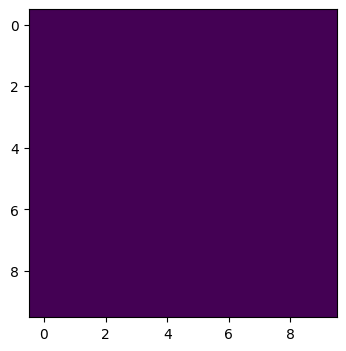

Evaluation 2 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.93it/s]


Completed. Saving
Time (s) to complete simulation 2: 0.8130655288696289


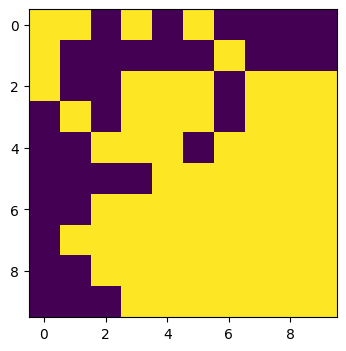

Evaluation 3 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.92it/s]


Completed. Saving
Time (s) to complete simulation 3: 0.8138813972473145


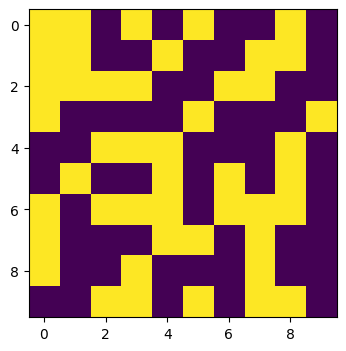

Evaluation 4 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.81it/s]


Completed. Saving
Time (s) to complete simulation 4: 0.7903141975402832


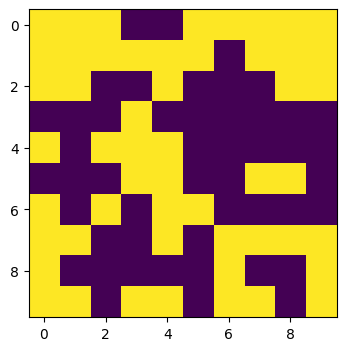

Evaluation 5 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.19it/s]


Completed. Saving
Time (s) to complete simulation 5: 0.8107478618621826


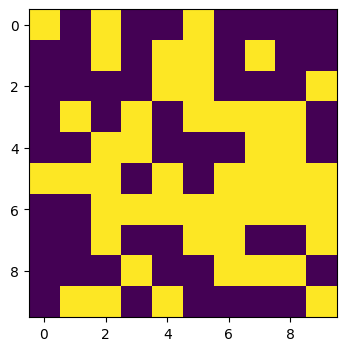

Evaluation 6 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.63it/s]


Completed. Saving
Time (s) to complete simulation 6: 0.8266942501068115


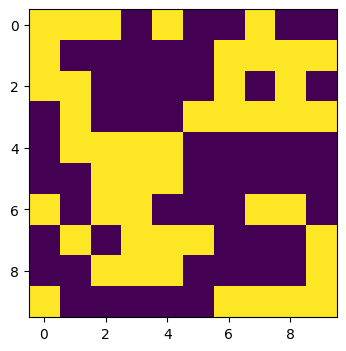

Evaluation 7 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.56it/s]


Completed. Saving
Time (s) to complete simulation 7: 0.7931525707244873


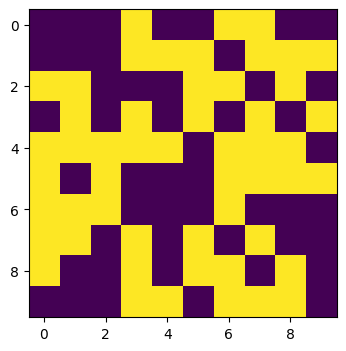

Evaluation 8 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.65it/s]


Completed. Saving
Time (s) to complete simulation 8: 0.8134582042694092


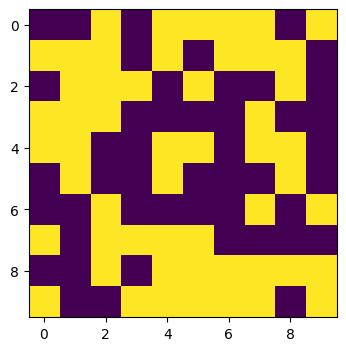

Evaluation 9 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.91it/s]


Completed. Saving
Time (s) to complete simulation 9: 0.8008749485015869


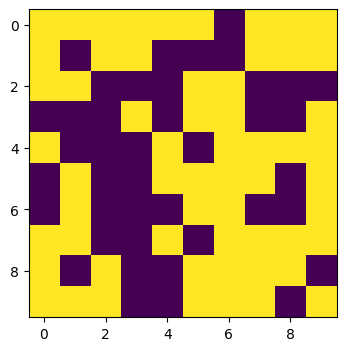

Evaluation 10 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 239.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.55it/s]


Completed. Saving
Time (s) to complete simulation 10: 0.7968919277191162


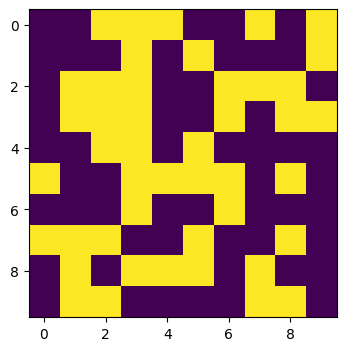

Evaluation 11 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 245.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.69it/s]


Completed. Saving
Time (s) to complete simulation 11: 0.810798168182373


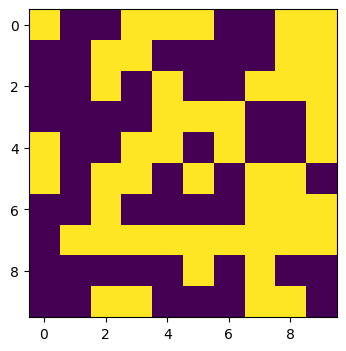

Evaluation 12 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.71it/s]


Completed. Saving
Time (s) to complete simulation 12: 1.4469935894012451


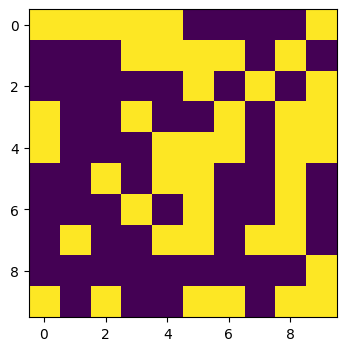

Evaluation 13 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 113.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.08it/s]


Completed. Saving
Time (s) to complete simulation 13: 1.5241482257843018


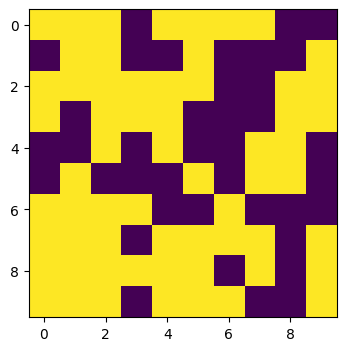

Evaluation 14 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 125.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


Completed. Saving
Time (s) to complete simulation 14: 1.3154027462005615


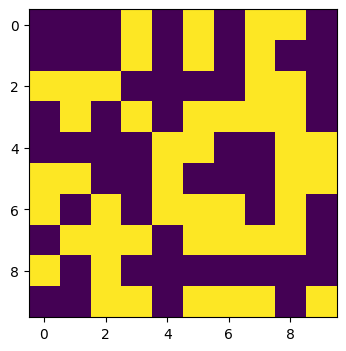

Evaluation 15 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.67it/s]


Completed. Saving
Time (s) to complete simulation 15: 0.7545626163482666


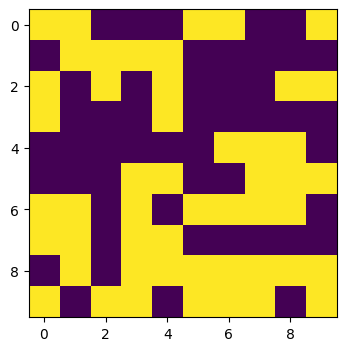

Evaluation 16 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 252.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.48it/s]


Completed. Saving
Time (s) to complete simulation 16: 0.747786283493042


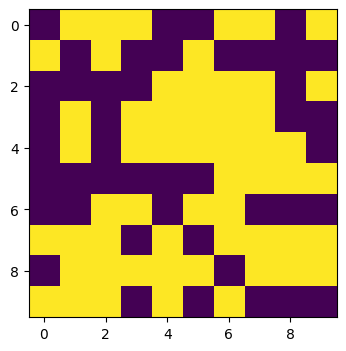

Evaluation 17 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 241.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.90it/s]


Completed. Saving
Time (s) to complete simulation 17: 0.7553026676177979


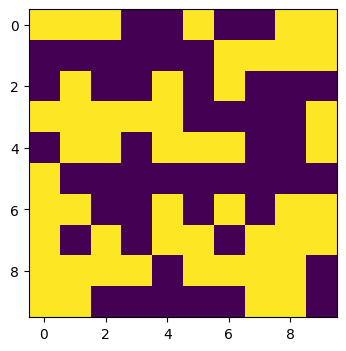

Evaluation 18 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 249.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.85it/s]


Completed. Saving
Time (s) to complete simulation 18: 0.7842774391174316


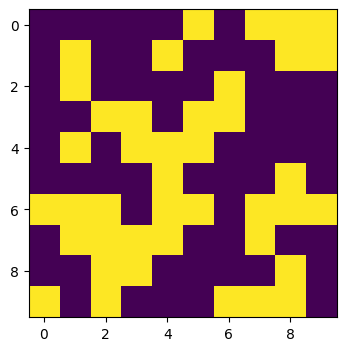

Evaluation 19 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.91it/s]


Completed. Saving
Time (s) to complete simulation 19: 0.780419111251831


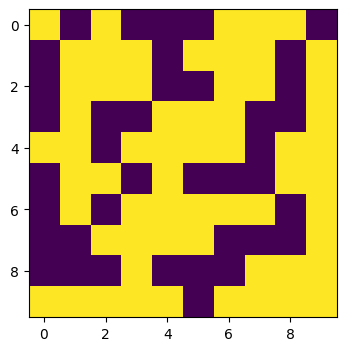

Evaluation 20 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.74it/s]


Completed. Saving
Time (s) to complete simulation 20: 0.7462387084960938


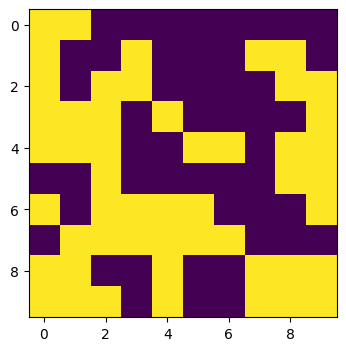

Evaluation 21 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.57it/s]


Completed. Saving
Time (s) to complete simulation 21: 0.7828834056854248


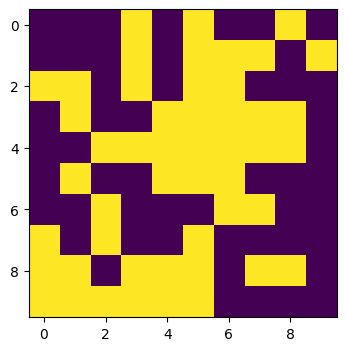

Evaluation 22 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.73it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.42it/s]


Completed. Saving
Time (s) to complete simulation 22: 0.7744510173797607


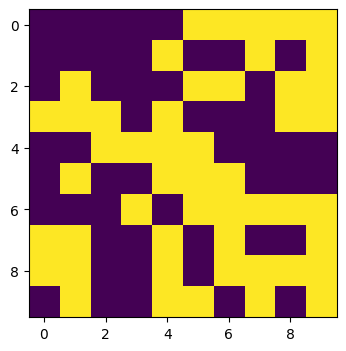

Evaluation 23 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.08it/s]


Completed. Saving
Time (s) to complete simulation 23: 1.4368431568145752


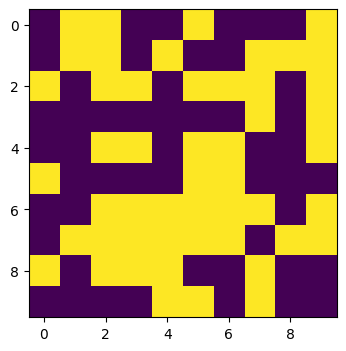

Evaluation 24 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.96it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 58.25it/s]


Completed. Saving
Time (s) to complete simulation 24: 1.2510898113250732


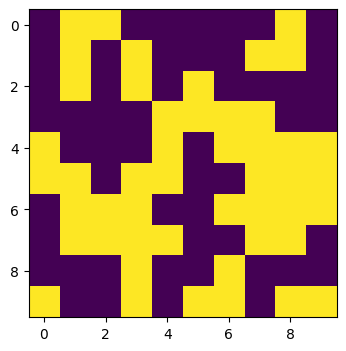

Evaluation 25 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.04it/s]


Completed. Saving
Time (s) to complete simulation 25: 0.7741837501525879


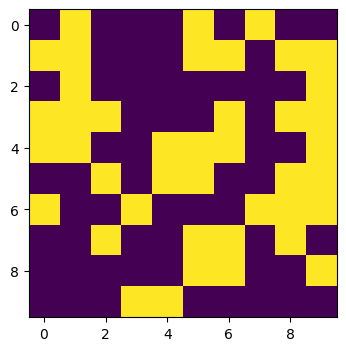

Evaluation 26 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 226.75it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.31it/s]


Completed. Saving
Time (s) to complete simulation 26: 0.7801241874694824


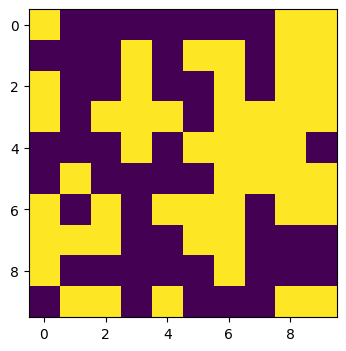

Evaluation 27 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.97it/s]


Completed. Saving
Time (s) to complete simulation 27: 0.7971854209899902


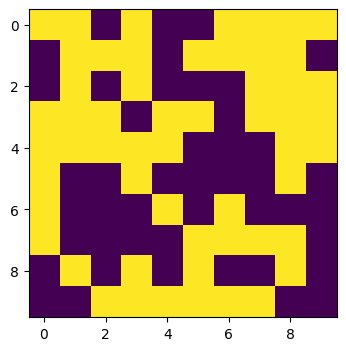

Evaluation 28 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.30it/s]


Completed. Saving
Time (s) to complete simulation 28: 0.7938830852508545


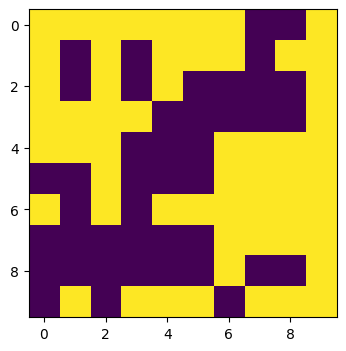

Evaluation 29 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.42it/s]


Completed. Saving
Time (s) to complete simulation 29: 0.7825255393981934


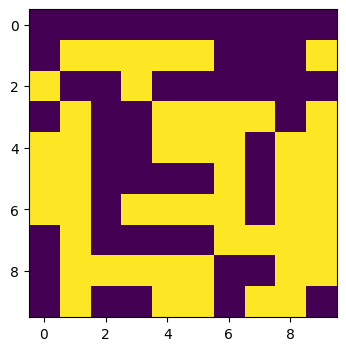

Evaluation 30 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 245.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.46it/s]


Completed. Saving
Time (s) to complete simulation 30: 0.7816920280456543


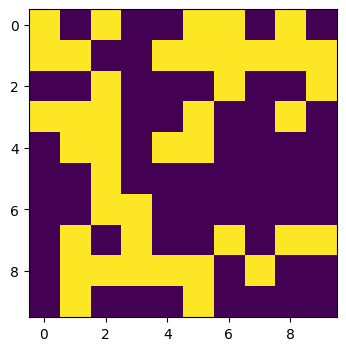

Evaluation 31 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.02it/s]


Completed. Saving
Time (s) to complete simulation 31: 0.8028335571289062


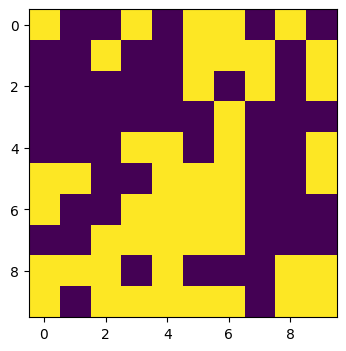

Evaluation 32 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 232.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.13it/s]


Completed. Saving
Time (s) to complete simulation 32: 0.7850508689880371


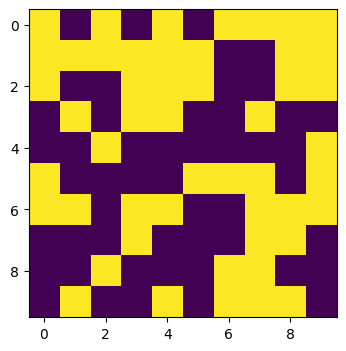

Evaluation 33 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.85it/s]


Completed. Saving
Time (s) to complete simulation 33: 0.7782106399536133


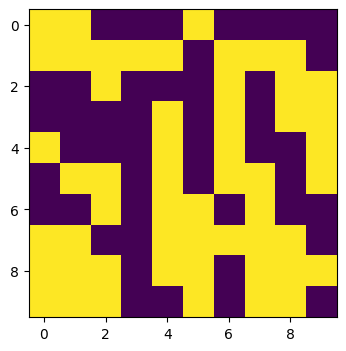

Evaluation 34 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 243.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.57it/s]


Completed. Saving
Time (s) to complete simulation 34: 0.7794911861419678


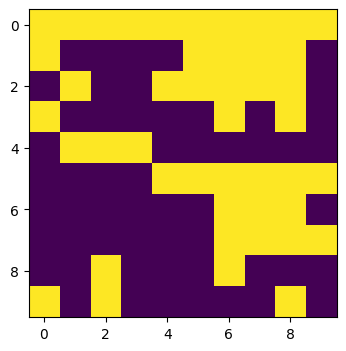

Evaluation 35 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 142.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.07it/s]


Completed. Saving
Time (s) to complete simulation 35: 1.3868353366851807


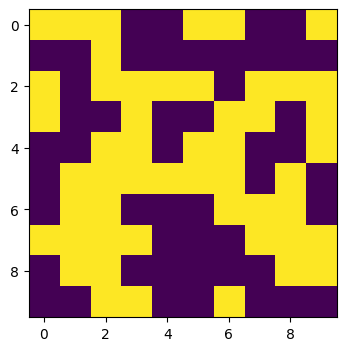

Evaluation 36 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 122.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


Completed. Saving
Time (s) to complete simulation 36: 1.3194432258605957


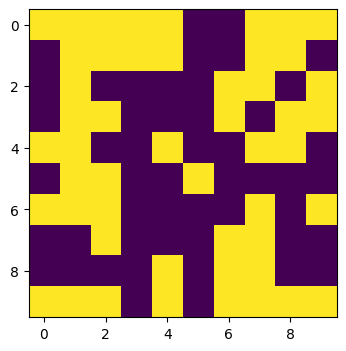

Evaluation 37 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.41it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.57it/s]


Completed. Saving
Time (s) to complete simulation 37: 0.7819361686706543


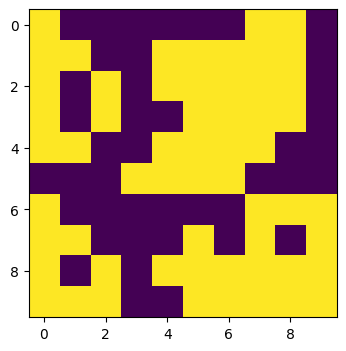

Evaluation 38 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.16it/s]


Completed. Saving
Time (s) to complete simulation 38: 0.7839505672454834


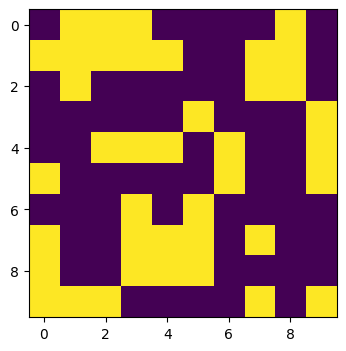

Evaluation 39 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.31it/s]


Completed. Saving
Time (s) to complete simulation 39: 0.8096163272857666


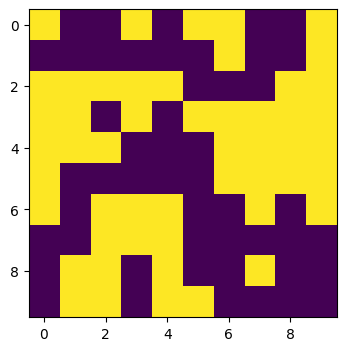

Evaluation 40 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.60it/s]


Completed. Saving
Time (s) to complete simulation 40: 0.8216869831085205


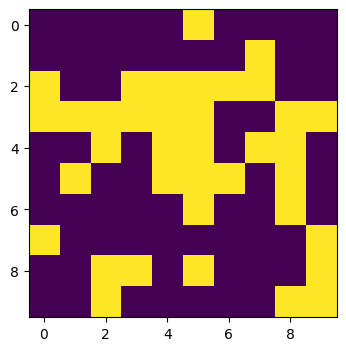

Evaluation 41 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.78it/s]


Completed. Saving
Time (s) to complete simulation 41: 0.7970757484436035


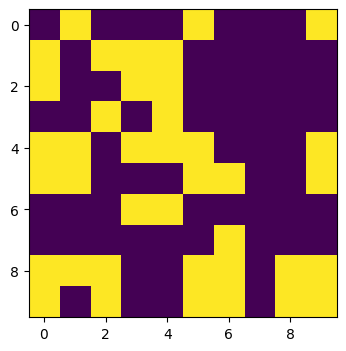

Evaluation 42 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 214.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.80it/s]


Completed. Saving
Time (s) to complete simulation 42: 0.8040952682495117


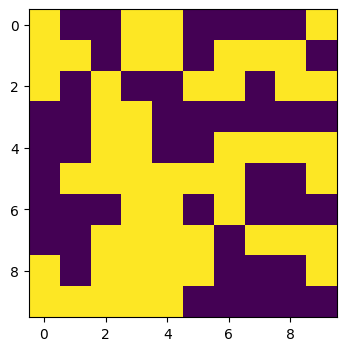

Evaluation 43 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.57it/s]


Completed. Saving
Time (s) to complete simulation 43: 0.8216650485992432


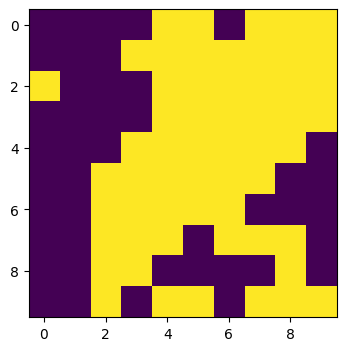

Evaluation 44 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.66it/s]


Completed. Saving
Time (s) to complete simulation 44: 0.8047475814819336


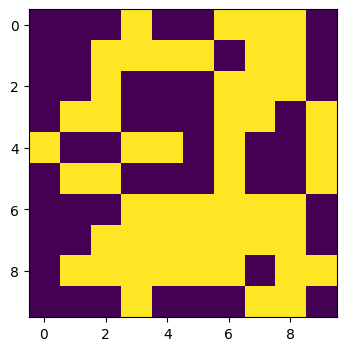

Evaluation 45 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.65it/s]


Completed. Saving
Time (s) to complete simulation 45: 0.8095128536224365


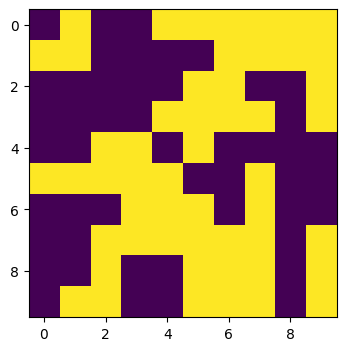

Evaluation 46 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 234.97it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.28it/s]


Completed. Saving
Time (s) to complete simulation 46: 0.8029181957244873


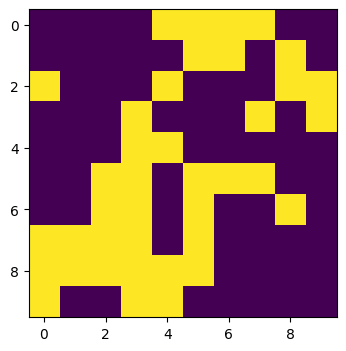

Evaluation 47 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.92it/s]


Completed. Saving
Time (s) to complete simulation 47: 1.4040906429290771


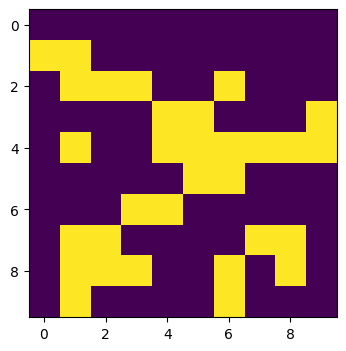

Evaluation 48 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 135.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 60.96it/s]


Completed. Saving
Time (s) to complete simulation 48: 1.2106585502624512


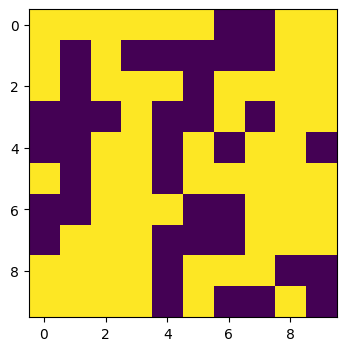

Evaluation 49 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.93it/s]


Completed. Saving
Time (s) to complete simulation 49: 0.817399263381958


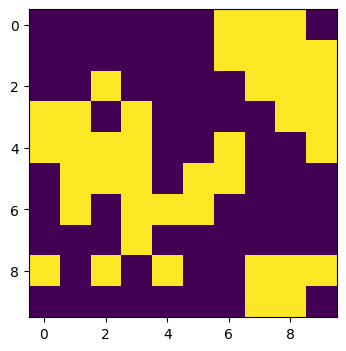

Evaluation 50 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.46it/s]


Completed. Saving
Time (s) to complete simulation 50: 0.8019375801086426


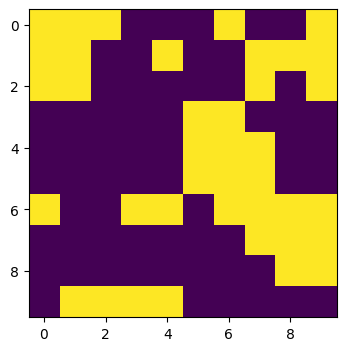

Evaluation 51 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.78it/s]


Completed. Saving
Time (s) to complete simulation 51: 0.8026797771453857


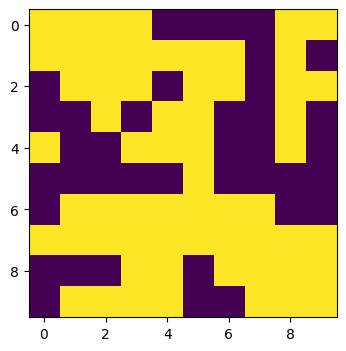

Evaluation 52 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.62it/s]


Completed. Saving
Time (s) to complete simulation 52: 0.8185579776763916


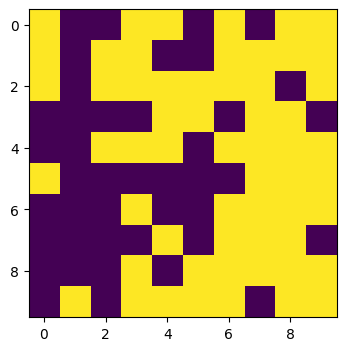

Evaluation 53 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.84it/s]


Completed. Saving
Time (s) to complete simulation 53: 0.8061251640319824


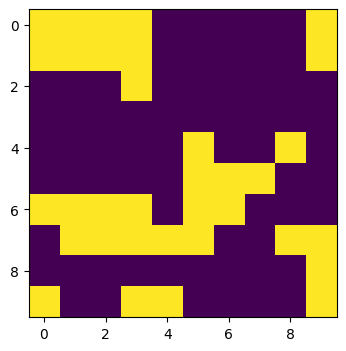

Evaluation 54 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.56it/s]


Completed. Saving
Time (s) to complete simulation 54: 0.8128457069396973


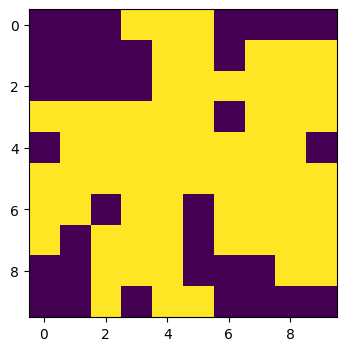

Evaluation 55 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.22it/s]


Completed. Saving
Time (s) to complete simulation 55: 0.8254489898681641


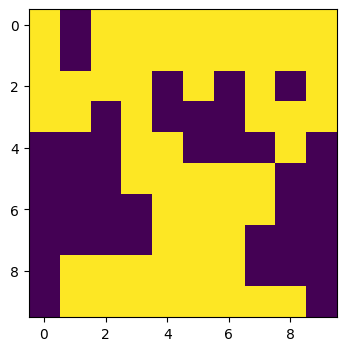

Evaluation 56 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.70it/s]


Completed. Saving
Time (s) to complete simulation 56: 0.8057332038879395


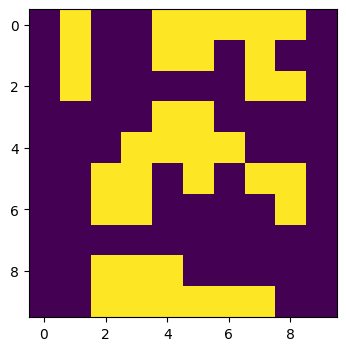

Evaluation 57 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 218.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.44it/s]


Completed. Saving
Time (s) to complete simulation 57: 0.8126246929168701


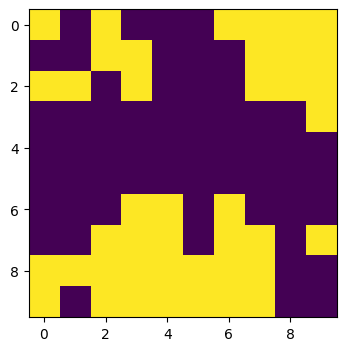

Evaluation 58 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.37it/s]


Completed. Saving
Time (s) to complete simulation 58: 0.9261095523834229


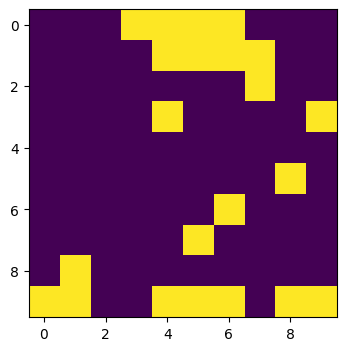

Evaluation 59 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.96it/s]


Completed. Saving
Time (s) to complete simulation 59: 1.4302616119384766


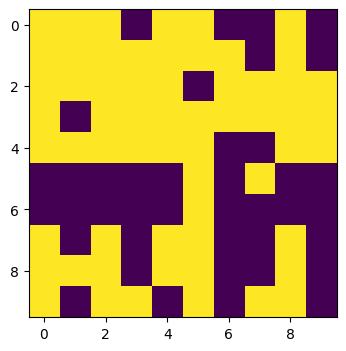

Evaluation 60 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 133.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 68.82it/s]


Completed. Saving
Time (s) to complete simulation 60: 1.1186463832855225


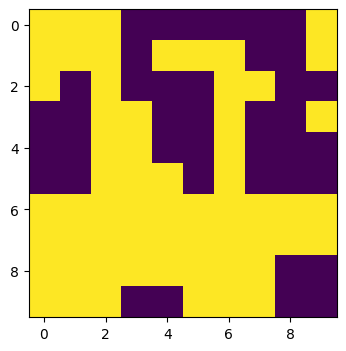

Evaluation 61 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.18it/s]


Completed. Saving
Time (s) to complete simulation 61: 0.8118307590484619


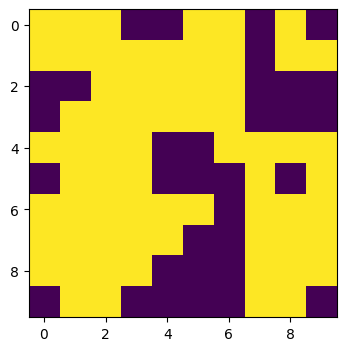

Evaluation 62 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.55it/s]


Completed. Saving
Time (s) to complete simulation 62: 0.8023223876953125


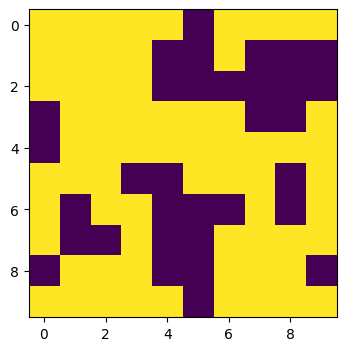

Evaluation 63 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.23it/s]


Completed. Saving
Time (s) to complete simulation 63: 0.7966718673706055


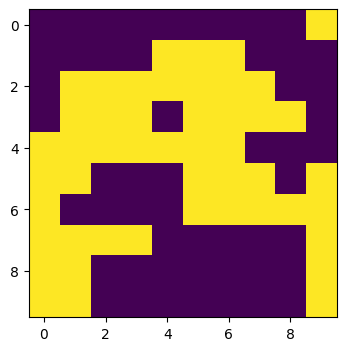

Evaluation 64 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.13it/s]


Completed. Saving
Time (s) to complete simulation 64: 0.8039689064025879


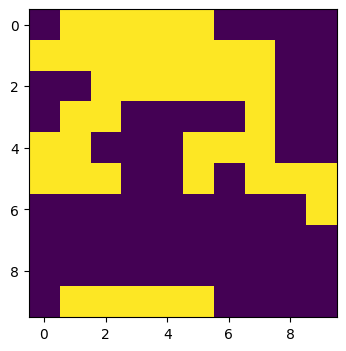

Evaluation 65 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.30it/s]


Completed. Saving
Time (s) to complete simulation 65: 0.8066461086273193


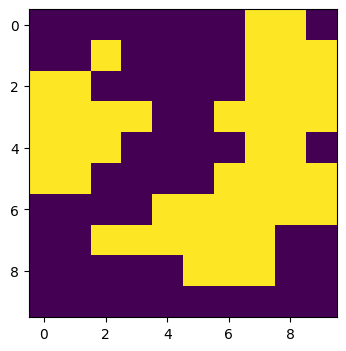

Evaluation 66 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 242.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.34it/s]


Completed. Saving
Time (s) to complete simulation 66: 0.7699973583221436


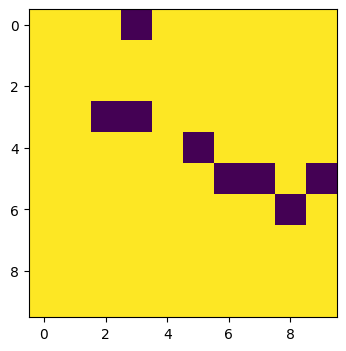

Evaluation 67 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.92it/s]


Completed. Saving
Time (s) to complete simulation 67: 0.8229591846466064


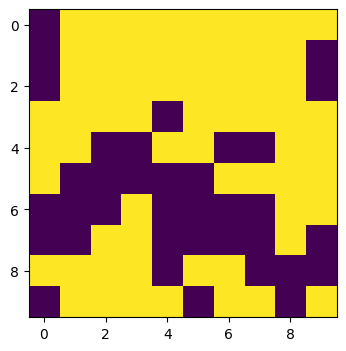

Evaluation 68 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.27it/s]


Completed. Saving
Time (s) to complete simulation 68: 0.7909104824066162


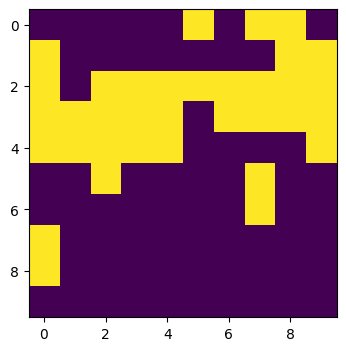

Evaluation 69 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.76it/s]


Completed. Saving
Time (s) to complete simulation 69: 0.803520917892456


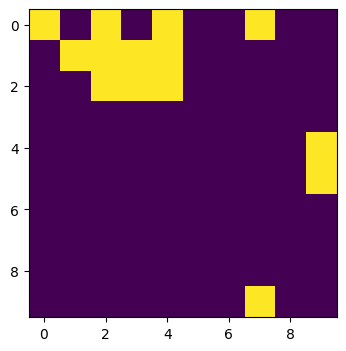

Evaluation 70 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.64it/s]


Completed. Saving
Time (s) to complete simulation 70: 1.1606390476226807


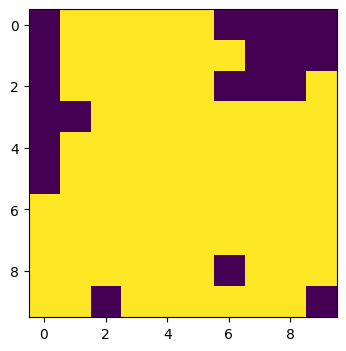

Evaluation 71 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 124.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.30it/s]


Completed. Saving
Time (s) to complete simulation 71: 1.417259693145752


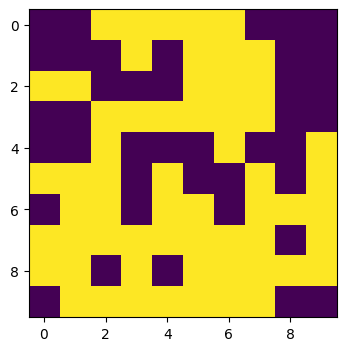

Evaluation 72 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 165.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.03it/s]


Completed. Saving
Time (s) to complete simulation 72: 0.8686721324920654


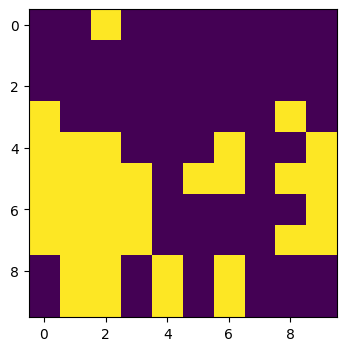

Evaluation 73 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.94it/s]


Completed. Saving
Time (s) to complete simulation 73: 0.8163833618164062


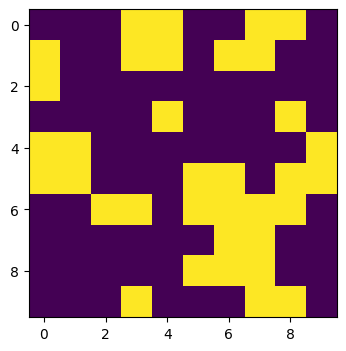

Evaluation 74 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.79it/s]


Completed. Saving
Time (s) to complete simulation 74: 0.8206801414489746


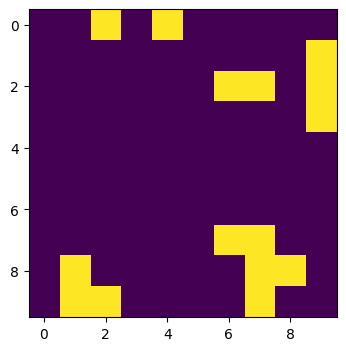

Evaluation 75 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.52it/s]


Completed. Saving
Time (s) to complete simulation 75: 0.8298797607421875


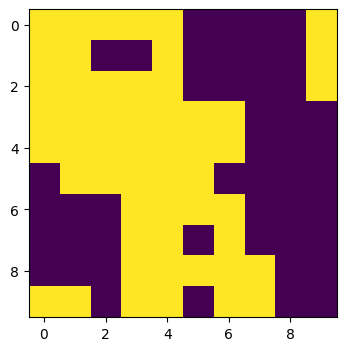

Evaluation 76 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.68it/s]


Completed. Saving
Time (s) to complete simulation 76: 0.8079566955566406


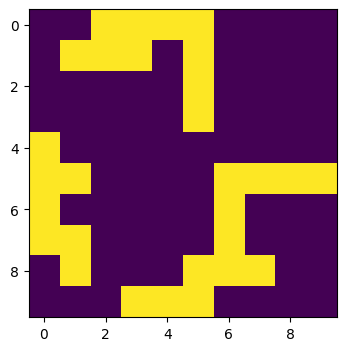

Evaluation 77 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.05it/s]


Completed. Saving
Time (s) to complete simulation 77: 0.8271660804748535


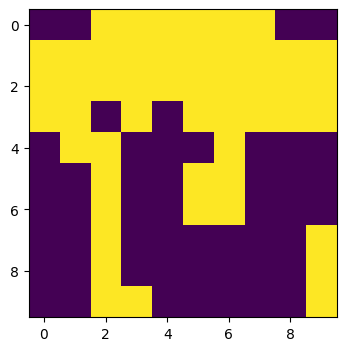

Evaluation 78 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.45it/s]


Completed. Saving
Time (s) to complete simulation 78: 0.8152432441711426


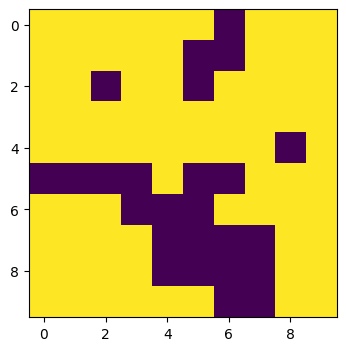

Evaluation 79 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.74it/s]


Completed. Saving
Time (s) to complete simulation 79: 0.8062689304351807


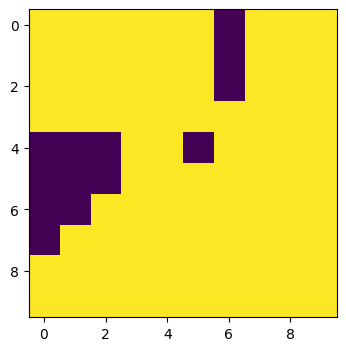

Evaluation 80 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.88it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.28it/s]


Completed. Saving
Time (s) to complete simulation 80: 0.8207330703735352


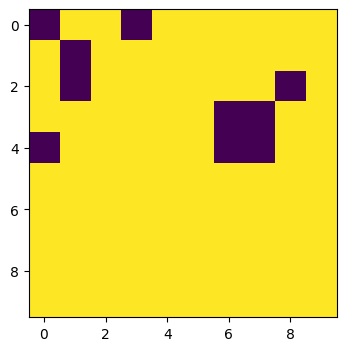

Evaluation 81 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 74.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.21it/s]


Completed. Saving
Time (s) to complete simulation 81: 1.3707377910614014


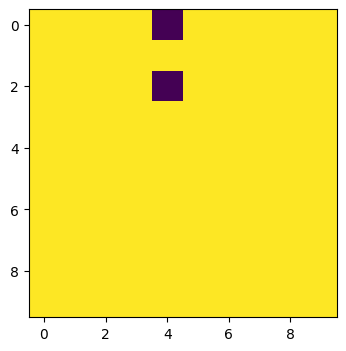

Evaluation 82 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 145.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.42it/s]


Completed. Saving
Time (s) to complete simulation 82: 1.4166643619537354


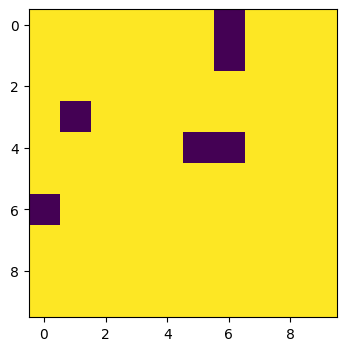

Evaluation 83 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 125.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 66.15it/s]


Completed. Saving
Time (s) to complete simulation 83: 1.1748261451721191


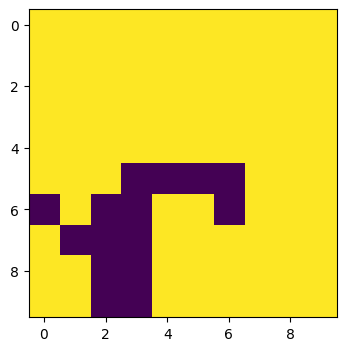

Evaluation 84 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.29it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.37it/s]


Completed. Saving
Time (s) to complete simulation 84: 0.8146710395812988


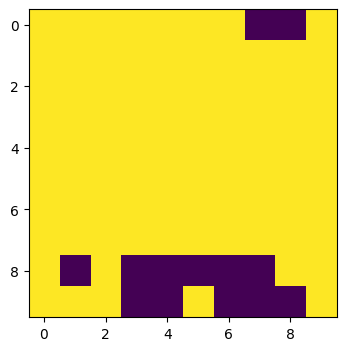

Evaluation 85 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.29it/s]


Completed. Saving
Time (s) to complete simulation 85: 0.8556597232818604


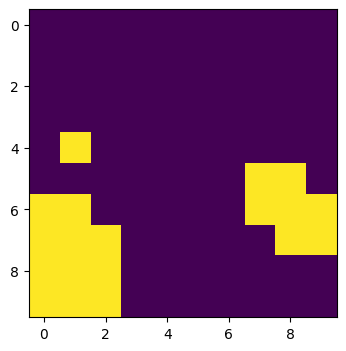

Evaluation 86 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.32it/s]


Completed. Saving
Time (s) to complete simulation 86: 0.8272049427032471


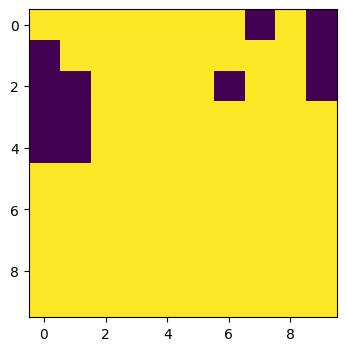

Evaluation 87 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 232.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.17it/s]


Completed. Saving
Time (s) to complete simulation 87: 0.8184928894042969


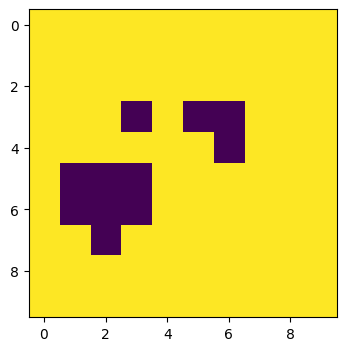

Evaluation 88 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.32it/s]


Completed. Saving
Time (s) to complete simulation 88: 0.8296623229980469


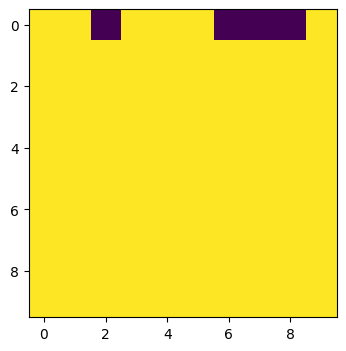

Evaluation 89 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.45it/s]


Completed. Saving
Time (s) to complete simulation 89: 0.8223719596862793


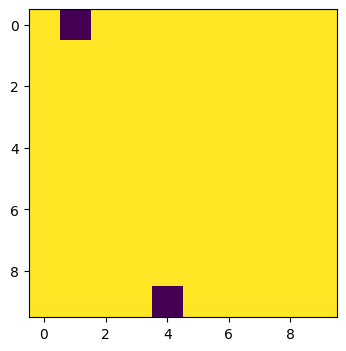

Evaluation 90 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.95it/s]


Completed. Saving
Time (s) to complete simulation 90: 0.8365545272827148


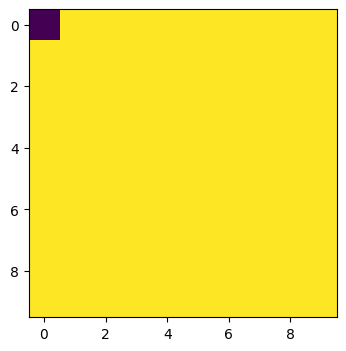

Evaluation 91 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.17it/s]


Completed. Saving
Time (s) to complete simulation 91: 0.8486216068267822


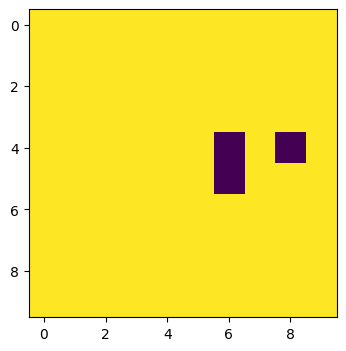

Evaluation 92 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.98it/s]


Completed. Saving
Time (s) to complete simulation 92: 0.8173129558563232


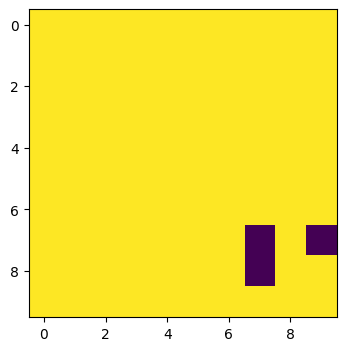

Evaluation 93 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.99it/s]


Completed. Saving
Time (s) to complete simulation 93: 1.2135860919952393


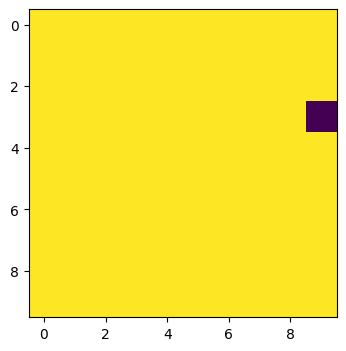

Evaluation 94 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.18it/s]


Completed. Saving
Time (s) to complete simulation 94: 1.3989667892456055


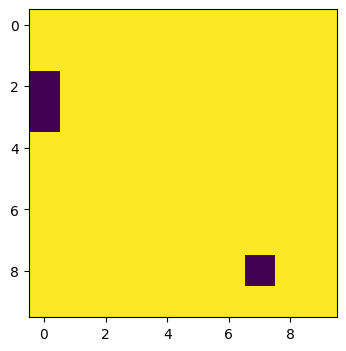

Evaluation 95 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 170.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.74it/s]


Completed. Saving
Time (s) to complete simulation 95: 0.8889865875244141


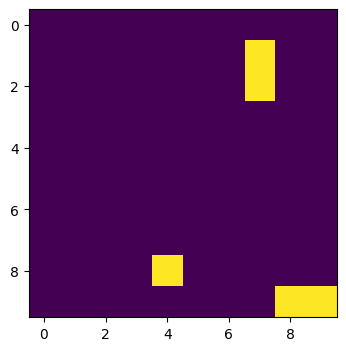

Evaluation 96 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.46it/s]


Completed. Saving
Time (s) to complete simulation 96: 0.836522102355957


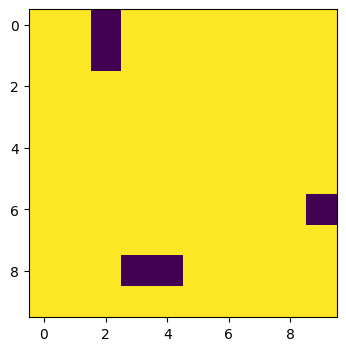

Evaluation 97 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.97it/s]


Completed. Saving
Time (s) to complete simulation 97: 0.8429830074310303


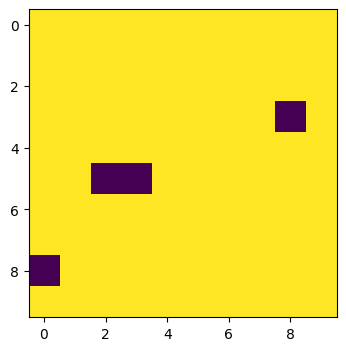

Evaluation 98 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.02it/s]


Completed. Saving
Time (s) to complete simulation 98: 0.8340179920196533


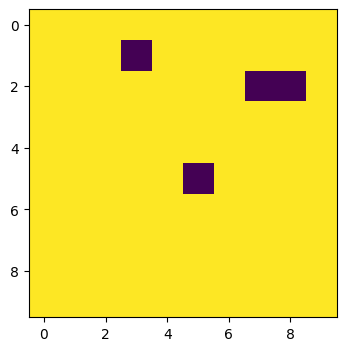

Evaluation 99 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.59it/s]


Completed. Saving
Time (s) to complete simulation 99: 0.8192319869995117


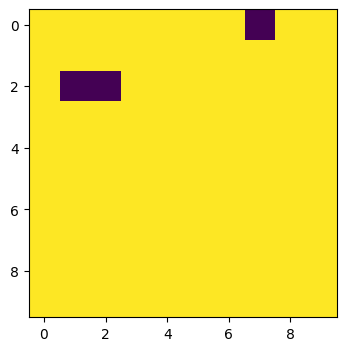

Evaluation 100 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.29it/s]


Completed. Saving
Time (s) to complete simulation 100: 0.8294072151184082


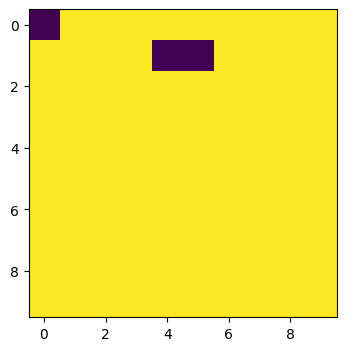

Evaluation 101 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.43it/s]


Completed. Saving
Time (s) to complete simulation 101: 0.8258535861968994


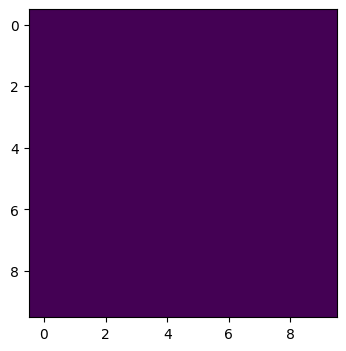

Evaluation 102 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.01it/s]


Completed. Saving
Time (s) to complete simulation 102: 0.8189878463745117


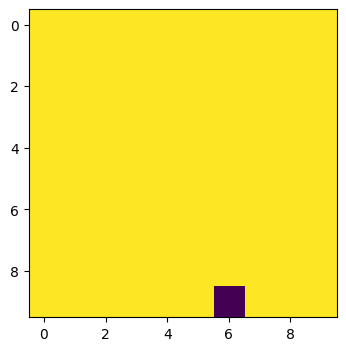

Evaluation 103 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.97it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.43it/s]


Completed. Saving
Time (s) to complete simulation 103: 0.8172736167907715


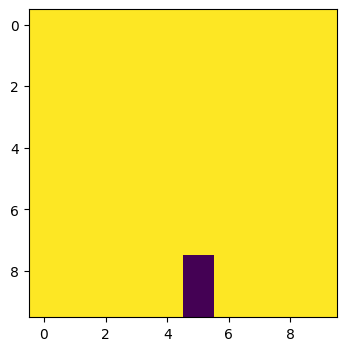

Evaluation 104 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.12it/s]


Completed. Saving
Time (s) to complete simulation 104: 0.835594654083252


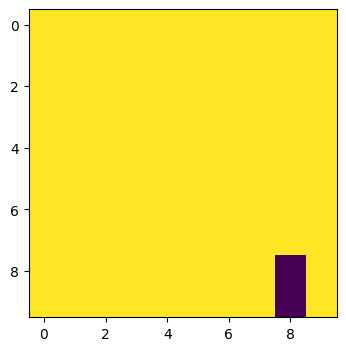

Evaluation 105 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.51it/s]


Completed. Saving
Time (s) to complete simulation 105: 1.4047017097473145


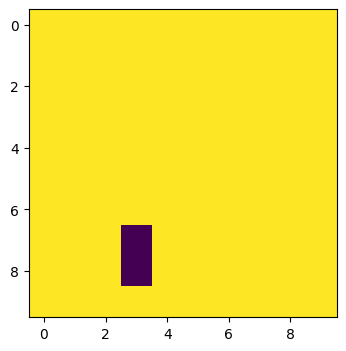

Evaluation 106 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.28it/s]


Completed. Saving
Time (s) to complete simulation 106: 1.3932936191558838


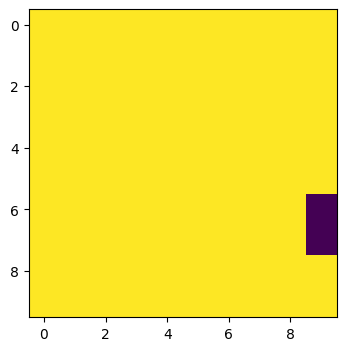

Evaluation 107 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.12it/s]


Completed. Saving
Time (s) to complete simulation 107: 0.8421635627746582


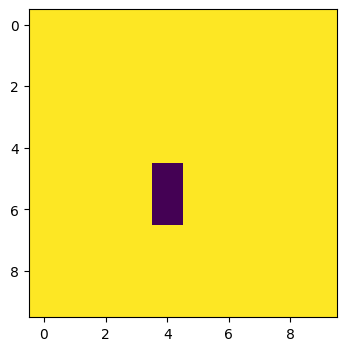

Evaluation 108 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.85it/s]


Completed. Saving
Time (s) to complete simulation 108: 0.8386423587799072


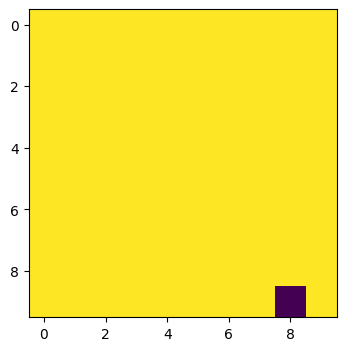

Evaluation 109 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.11it/s]


Completed. Saving
Time (s) to complete simulation 109: 0.8284120559692383


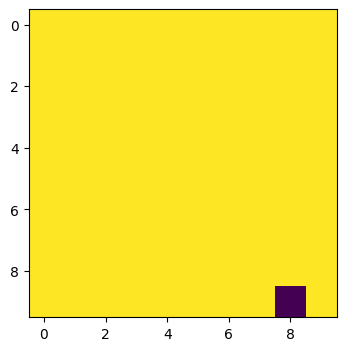

Evaluation 110 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.93it/s]


Completed. Saving
Time (s) to complete simulation 110: 0.8329308032989502


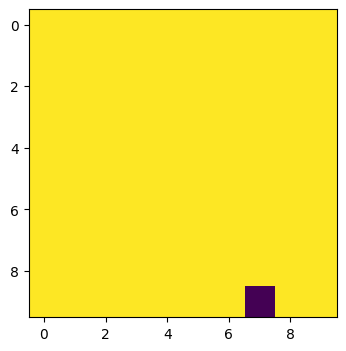

Evaluation 111 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.18it/s]


Completed. Saving
Time (s) to complete simulation 111: 0.8580348491668701


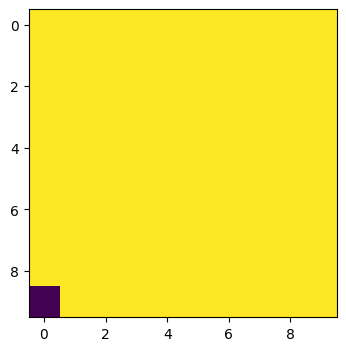

Evaluation 112 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.60it/s]


Completed. Saving
Time (s) to complete simulation 112: 0.8509171009063721


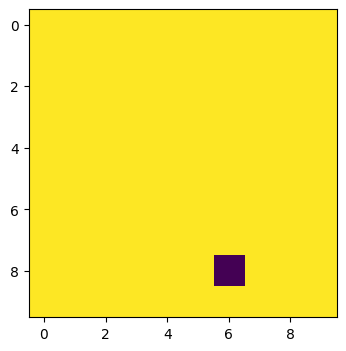

Evaluation 113 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.45it/s]


Completed. Saving
Time (s) to complete simulation 113: 0.8486678600311279


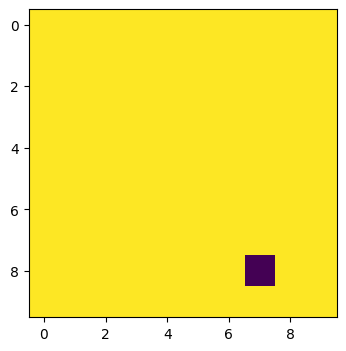

Evaluation 114 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.32it/s]


Completed. Saving
Time (s) to complete simulation 114: 0.856273889541626


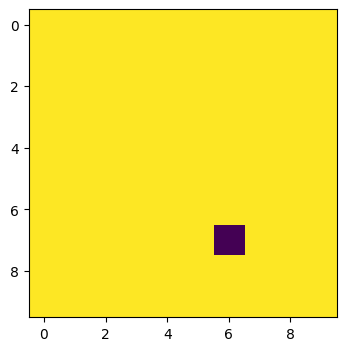

Evaluation 115 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.97it/s]


Completed. Saving
Time (s) to complete simulation 115: 0.8482658863067627


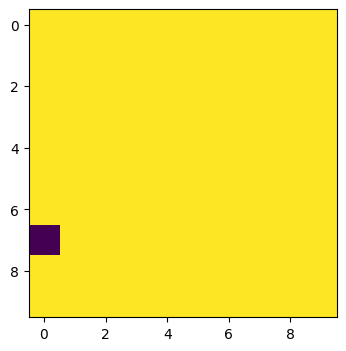

Evaluation 116 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.04it/s]


Completed. Saving
Time (s) to complete simulation 116: 1.2123692035675049


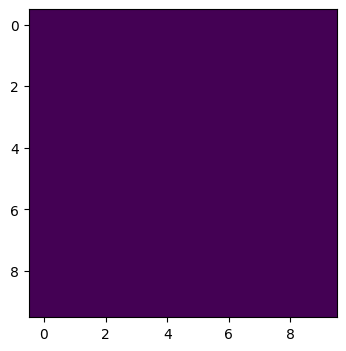

Evaluation 117 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.97it/s]


Completed. Saving
Time (s) to complete simulation 117: 1.4309062957763672


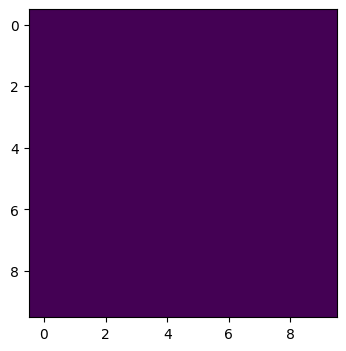

Evaluation 118 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.48it/s]


Completed. Saving
Time (s) to complete simulation 118: 0.9985635280609131


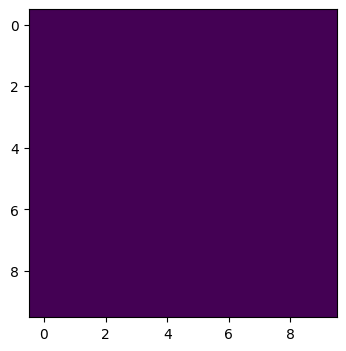

Evaluation 119 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.18it/s]


Completed. Saving
Time (s) to complete simulation 119: 0.8658747673034668


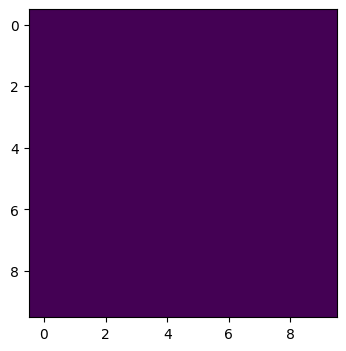

Evaluation 120 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.16it/s]


Completed. Saving
Time (s) to complete simulation 120: 0.8796329498291016


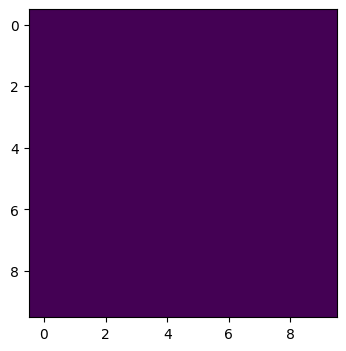

Evaluation 121 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.45it/s]


Completed. Saving
Time (s) to complete simulation 121: 0.8479163646697998


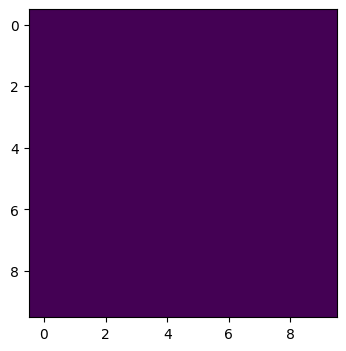

Evaluation 122 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.84it/s]


Completed. Saving
Time (s) to complete simulation 122: 0.8617739677429199


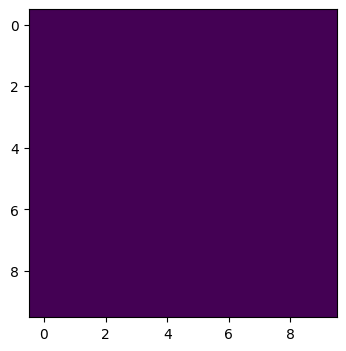

Evaluation 123 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.35it/s]


Completed. Saving
Time (s) to complete simulation 123: 0.8697123527526855


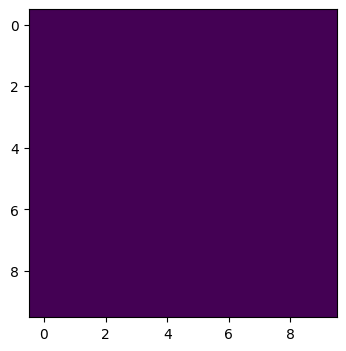

Evaluation 124 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.00it/s]


Completed. Saving
Time (s) to complete simulation 124: 0.8551986217498779


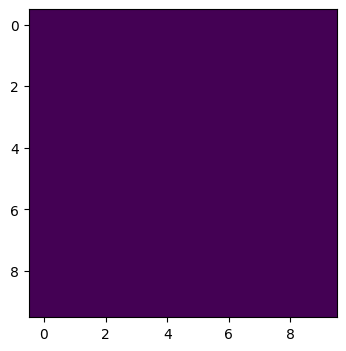

Evaluation 125 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.12it/s]


Completed. Saving
Time (s) to complete simulation 125: 0.874014139175415


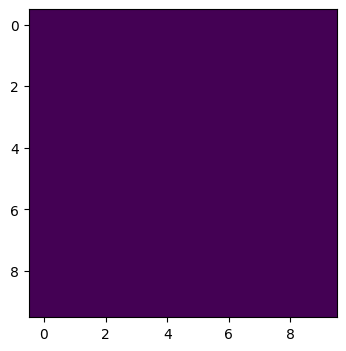

Evaluation 126 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.41it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.92it/s]


Completed. Saving
Time (s) to complete simulation 126: 0.8678326606750488


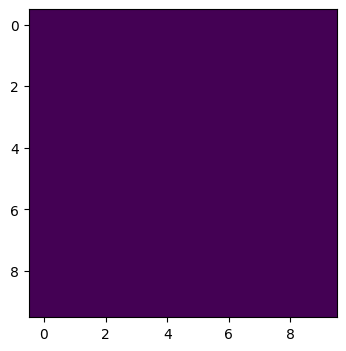

Evaluation 127 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 70.07it/s]


Completed. Saving
Time (s) to complete simulation 127: 0.9754054546356201


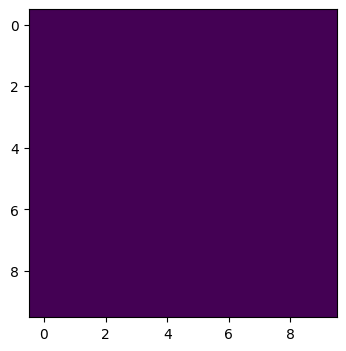

Evaluation 128 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 135.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.00it/s]


Completed. Saving
Time (s) to complete simulation 128: 1.3679347038269043


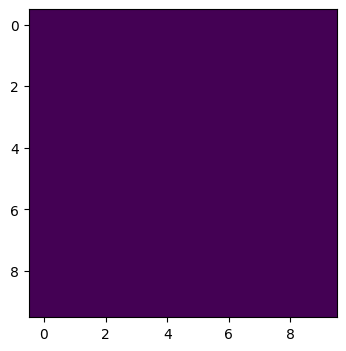

Evaluation 129 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


Completed. Saving
Time (s) to complete simulation 129: 1.3023121356964111


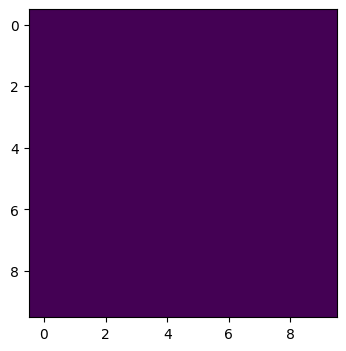

Evaluation 130 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.84it/s]


Completed. Saving
Time (s) to complete simulation 130: 0.8810062408447266


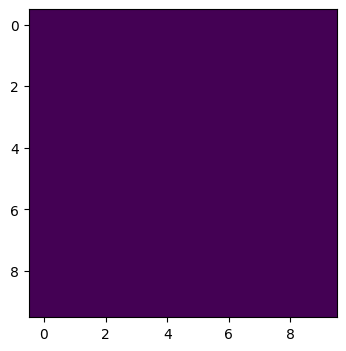

Evaluation 131 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.15it/s]


Completed. Saving
Time (s) to complete simulation 131: 0.8613877296447754


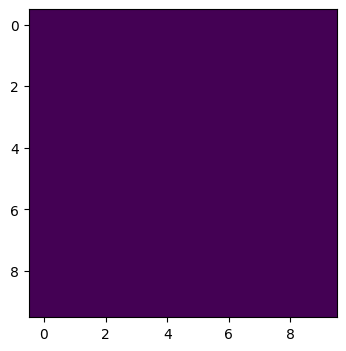

Evaluation 132 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 179.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.99it/s]


Completed. Saving
Time (s) to complete simulation 132: 0.8838813304901123


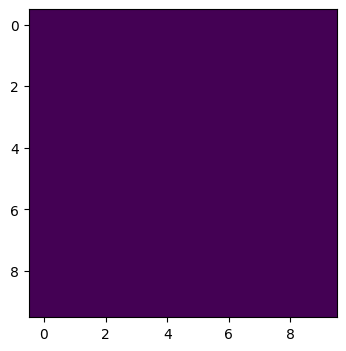

Evaluation 133 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.53it/s]


Completed. Saving
Time (s) to complete simulation 133: 0.870255708694458


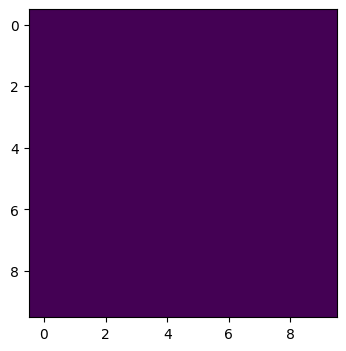

Evaluation 134 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.15it/s]


Completed. Saving
Time (s) to complete simulation 134: 0.8676362037658691


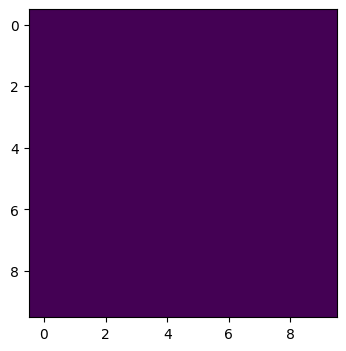

Evaluation 135 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.06it/s]


Completed. Saving
Time (s) to complete simulation 135: 0.8546881675720215


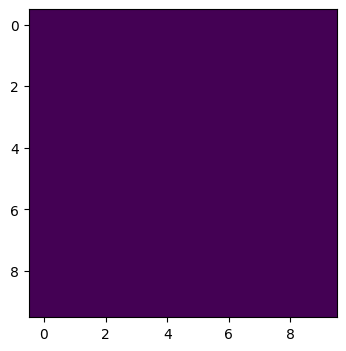

Evaluation 136 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.01it/s]


Completed. Saving
Time (s) to complete simulation 136: 0.8734946250915527


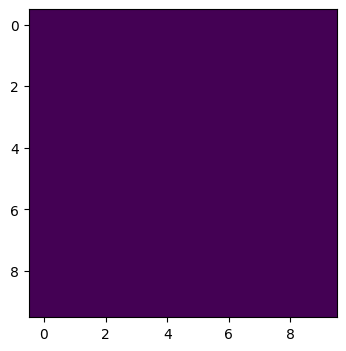

Evaluation 137 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.78it/s]


Completed. Saving
Time (s) to complete simulation 137: 0.8628618717193604


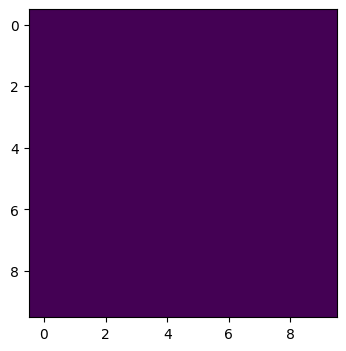

Evaluation 138 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.37it/s]


Completed. Saving
Time (s) to complete simulation 138: 0.8509335517883301


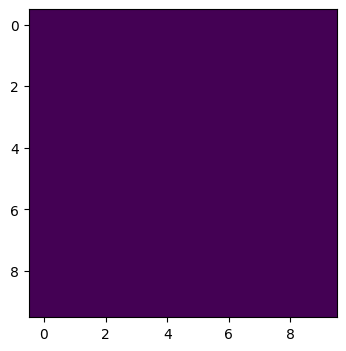

Evaluation 139 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 155.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.38it/s]


Completed. Saving
Time (s) to complete simulation 139: 1.3099277019500732


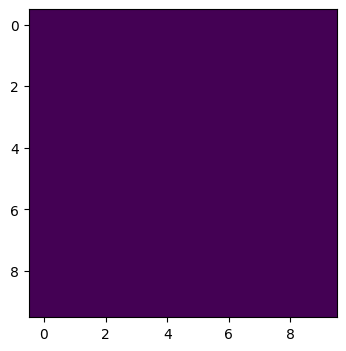

Evaluation 140 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 123.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.83it/s]


Completed. Saving
Time (s) to complete simulation 140: 1.434514045715332


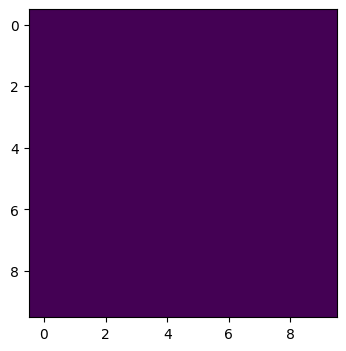

Evaluation 141 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 145.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.65it/s]


Completed. Saving
Time (s) to complete simulation 141: 0.9661703109741211


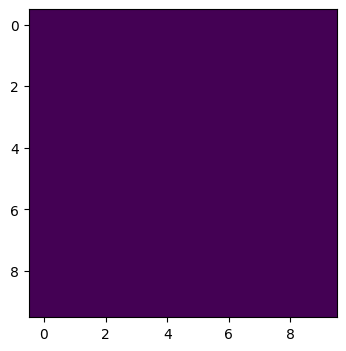

Evaluation 142 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.65it/s]


Completed. Saving
Time (s) to complete simulation 142: 0.8619964122772217


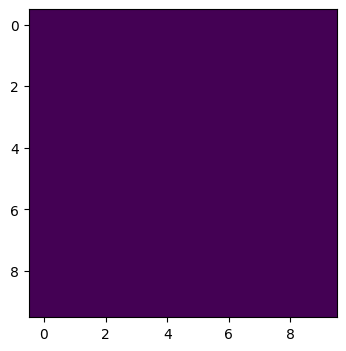

Evaluation 143 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.56it/s]


Completed. Saving
Time (s) to complete simulation 143: 0.8679587841033936


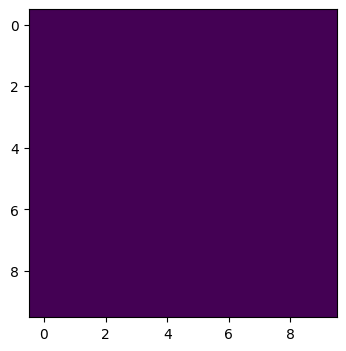

Evaluation 144 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.05it/s]


Completed. Saving
Time (s) to complete simulation 144: 0.8493142127990723


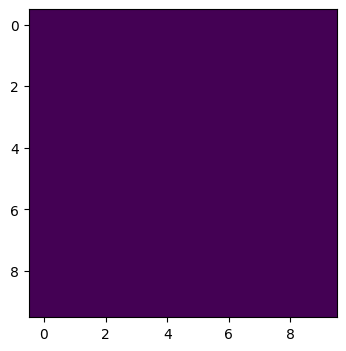

Evaluation 145 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.07it/s]


Completed. Saving
Time (s) to complete simulation 145: 0.8822872638702393


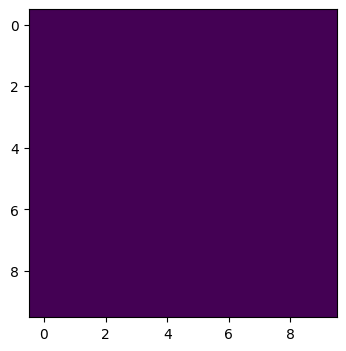

Evaluation 146 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.06it/s]


Completed. Saving
Time (s) to complete simulation 146: 0.8752315044403076


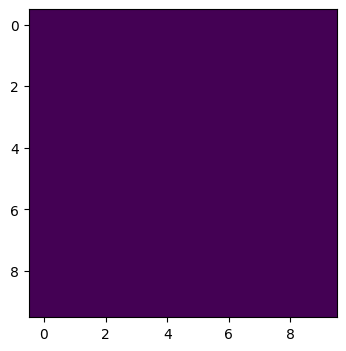

Evaluation 147 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.83it/s]


Completed. Saving
Time (s) to complete simulation 147: 0.894860029220581


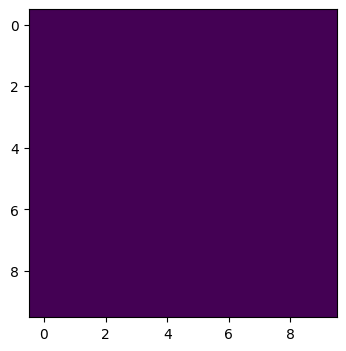

Evaluation 148 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.76it/s]


Completed. Saving
Time (s) to complete simulation 148: 0.8903157711029053


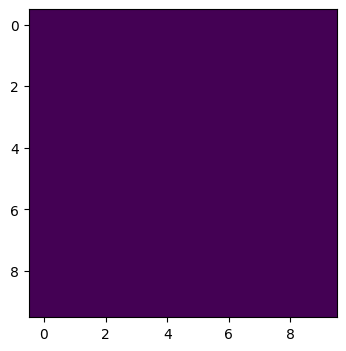

Evaluation 149 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.83it/s]


Completed. Saving
Time (s) to complete simulation 149: 0.8828437328338623


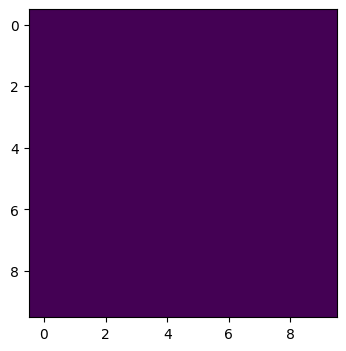

Evaluation 150 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.42it/s]


Completed. Saving
Time (s) to complete simulation 150: 1.1406140327453613


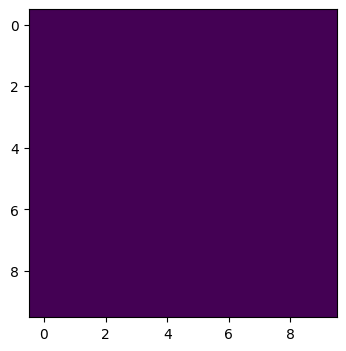

Evaluation 151 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.07it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.71it/s]


Completed. Saving
Time (s) to complete simulation 151: 1.4086534976959229


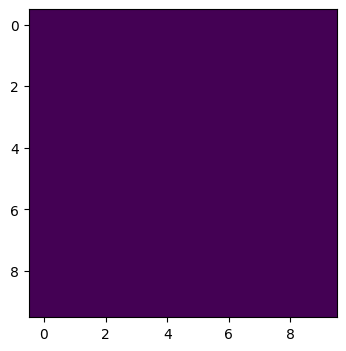

Evaluation 152 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.90it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.70it/s]


Completed. Saving
Time (s) to complete simulation 152: 1.2359070777893066


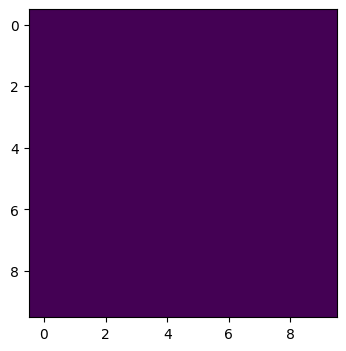

Evaluation 153 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.30it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.52it/s]


Completed. Saving
Time (s) to complete simulation 153: 0.8848352432250977


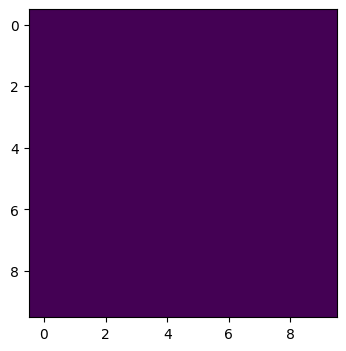

Evaluation 154 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.07it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.34it/s]


Completed. Saving
Time (s) to complete simulation 154: 0.8841221332550049


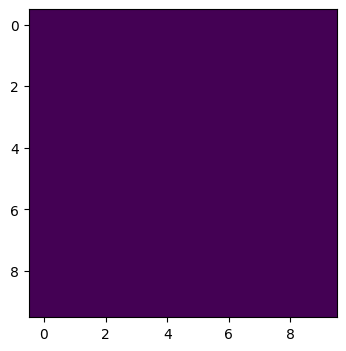

Evaluation 155 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.35it/s]


Completed. Saving
Time (s) to complete simulation 155: 0.8959815502166748


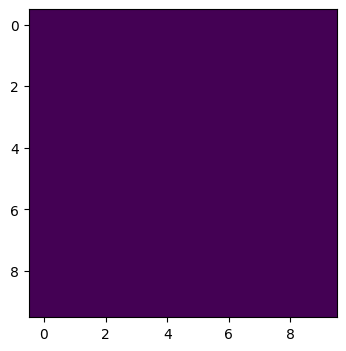

Evaluation 156 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.35it/s]


Completed. Saving
Time (s) to complete simulation 156: 0.9074034690856934


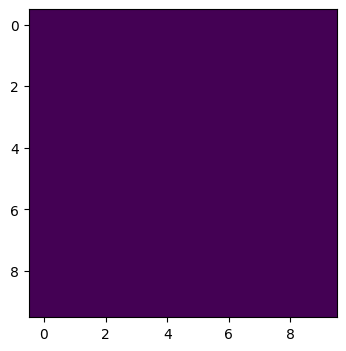

Evaluation 157 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.31it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.42it/s]


Completed. Saving
Time (s) to complete simulation 157: 0.8733193874359131


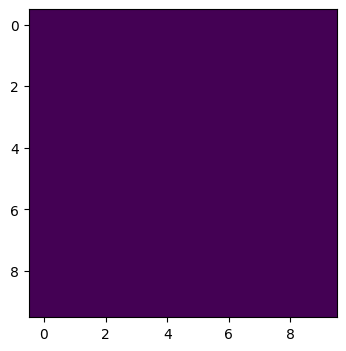

Evaluation 158 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.39it/s]


Completed. Saving
Time (s) to complete simulation 158: 0.8951804637908936


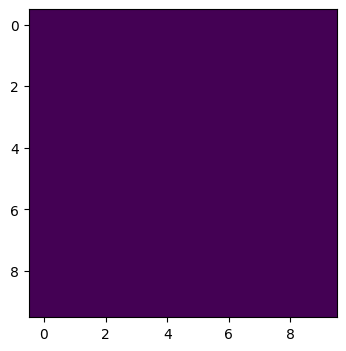

Evaluation 159 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.68it/s]


Completed. Saving
Time (s) to complete simulation 159: 0.892899751663208


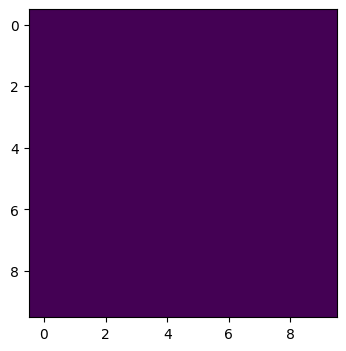

Evaluation 160 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.01it/s]


Completed. Saving
Time (s) to complete simulation 160: 0.8845455646514893


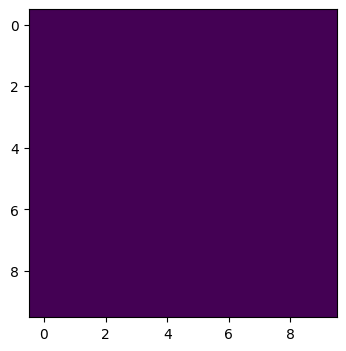

Evaluation 161 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 70.16it/s]


Completed. Saving
Time (s) to complete simulation 161: 0.9908449649810791


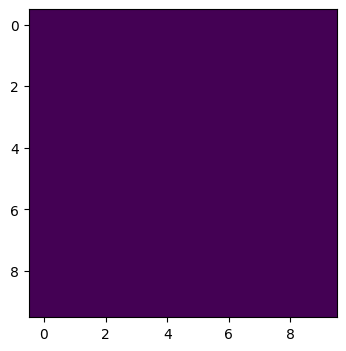

Evaluation 162 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.33it/s]


Completed. Saving
Time (s) to complete simulation 162: 1.3689570426940918


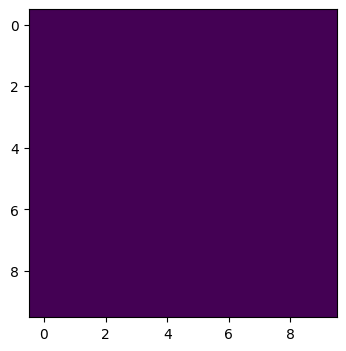

Evaluation 163 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 45.94it/s]


Completed. Saving
Time (s) to complete simulation 163: 1.5042955875396729


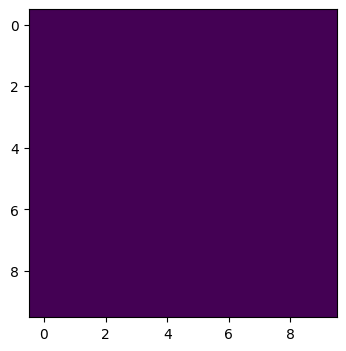

Evaluation 164 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 114.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.32it/s]


Completed. Saving
Time (s) to complete simulation 164: 1.4285383224487305


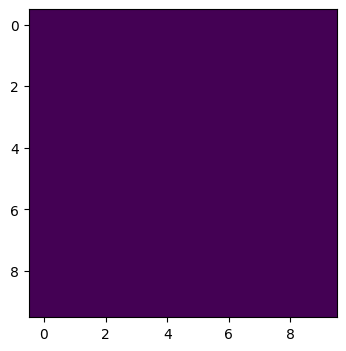

Evaluation 165 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.72it/s]


Completed. Saving
Time (s) to complete simulation 165: 1.395399808883667


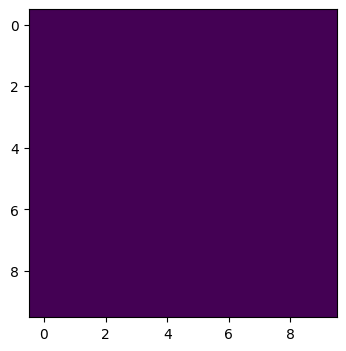

Evaluation 166 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.33it/s]


Completed. Saving
Time (s) to complete simulation 166: 0.8976993560791016


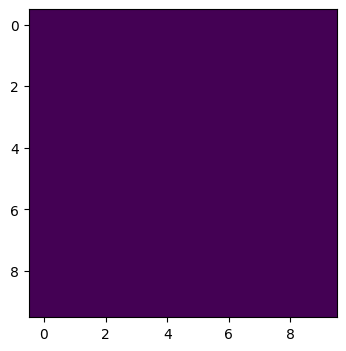

Evaluation 167 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.62it/s]


Completed. Saving
Time (s) to complete simulation 167: 0.895817756652832


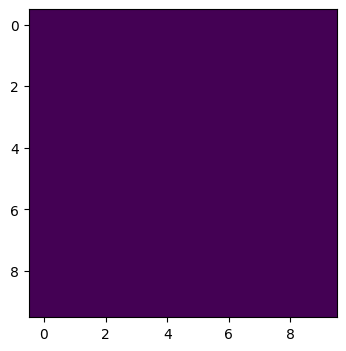

Evaluation 168 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.30it/s]


Completed. Saving
Time (s) to complete simulation 168: 0.8922097682952881


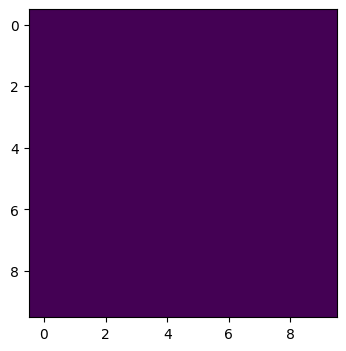

Evaluation 169 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.47it/s]


Completed. Saving
Time (s) to complete simulation 169: 0.8914511203765869


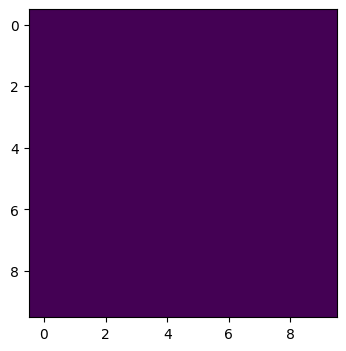

Evaluation 170 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.43it/s]


Completed. Saving
Time (s) to complete simulation 170: 0.8855879306793213


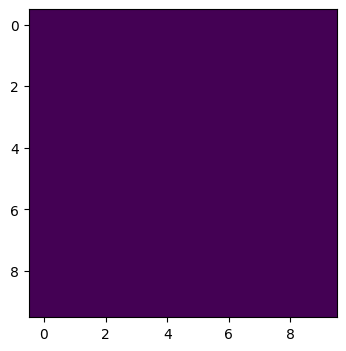

Evaluation 171 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.18it/s]


Completed. Saving
Time (s) to complete simulation 171: 0.906804084777832


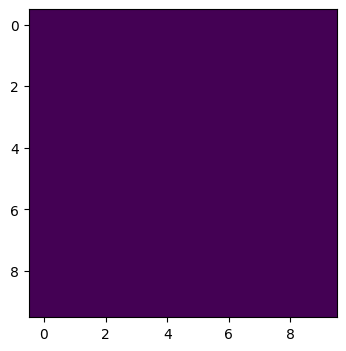

Evaluation 172 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 183.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.93it/s]


Completed. Saving
Time (s) to complete simulation 172: 1.3355014324188232


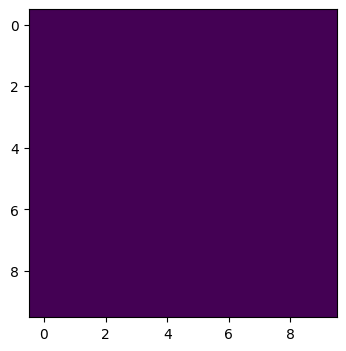

Evaluation 173 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 140.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.93it/s]


Completed. Saving
Time (s) to complete simulation 173: 1.3730857372283936


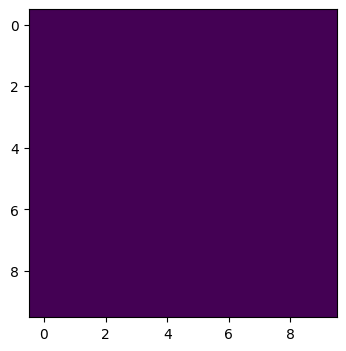

Evaluation 174 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 122.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 65.89it/s]


Completed. Saving
Time (s) to complete simulation 174: 1.1842150688171387


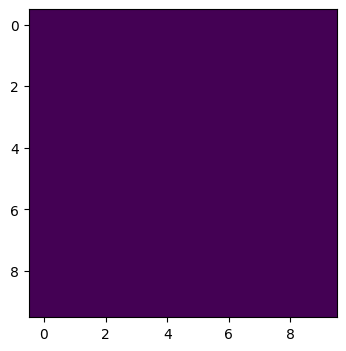

Evaluation 175 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.44it/s]


Completed. Saving
Time (s) to complete simulation 175: 0.9183759689331055


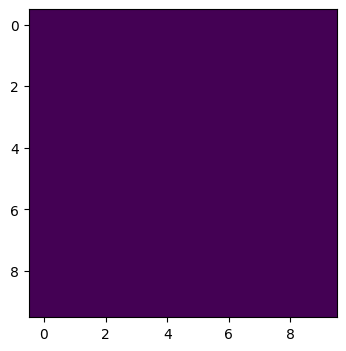

Evaluation 176 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.34it/s]


Completed. Saving
Time (s) to complete simulation 176: 0.9059436321258545


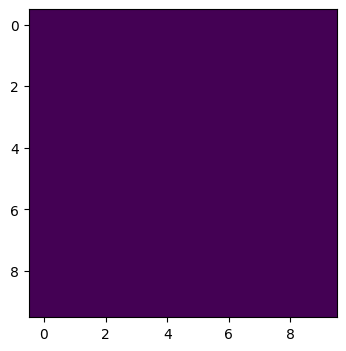

Evaluation 177 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.32it/s]


Completed. Saving
Time (s) to complete simulation 177: 0.9134478569030762


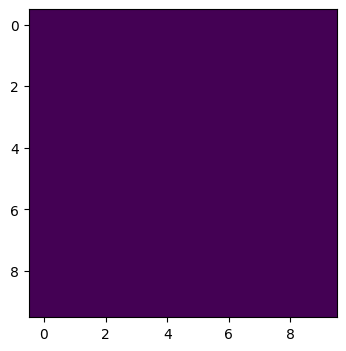

Evaluation 178 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 181.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.73it/s]


Completed. Saving
Time (s) to complete simulation 178: 0.9433269500732422


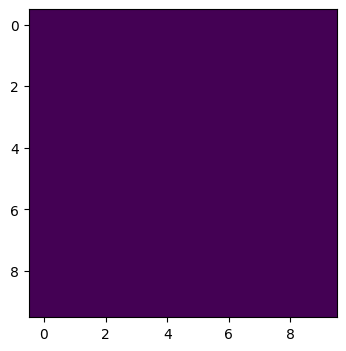

Evaluation 179 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.07it/s]


Completed. Saving
Time (s) to complete simulation 179: 0.90390944480896


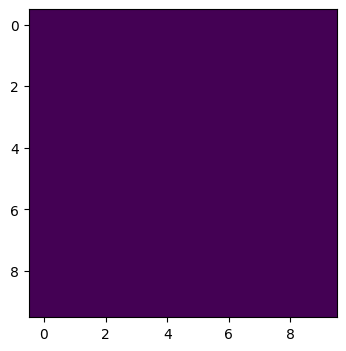

Evaluation 180 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.15it/s]


Completed. Saving
Time (s) to complete simulation 180: 0.923696756362915


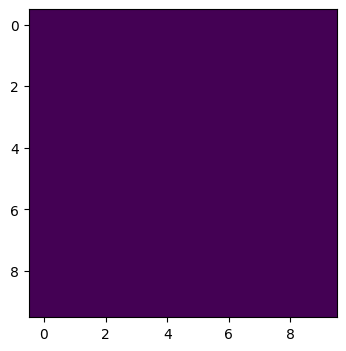

Evaluation 181 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.31it/s]


Completed. Saving
Time (s) to complete simulation 181: 0.8966727256774902


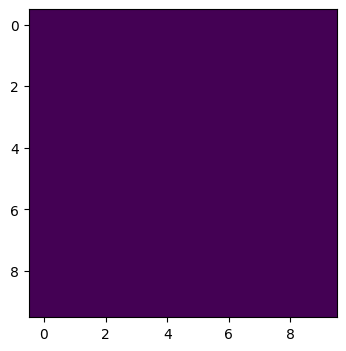

Evaluation 182 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 185.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.29it/s]


Completed. Saving
Time (s) to complete simulation 182: 0.9017374515533447


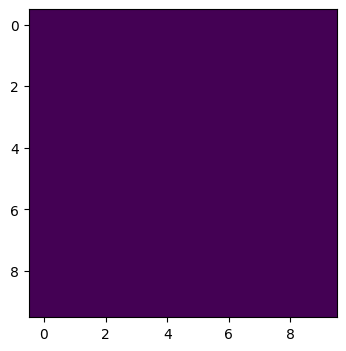

Evaluation 183 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 169.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.89it/s]


Completed. Saving
Time (s) to complete simulation 183: 1.2279853820800781


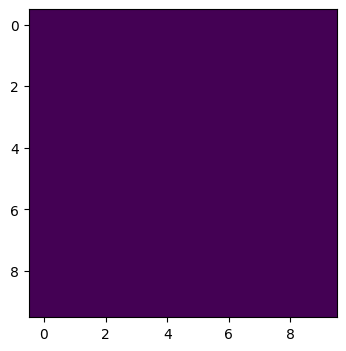

Evaluation 184 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.91it/s]


Completed. Saving
Time (s) to complete simulation 184: 1.4168574810028076


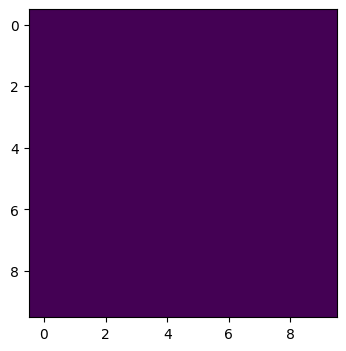

Evaluation 185 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 127.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 64.15it/s]


Completed. Saving
Time (s) to complete simulation 185: 1.1930575370788574


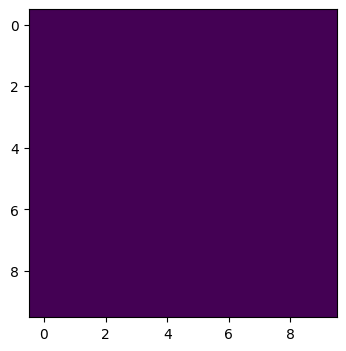

Evaluation 186 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 173.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.29it/s]


Completed. Saving
Time (s) to complete simulation 186: 0.9448668956756592


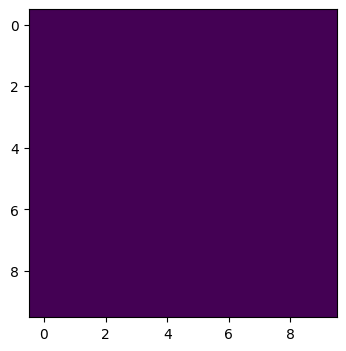

Evaluation 187 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.47it/s]


Completed. Saving
Time (s) to complete simulation 187: 0.9108071327209473


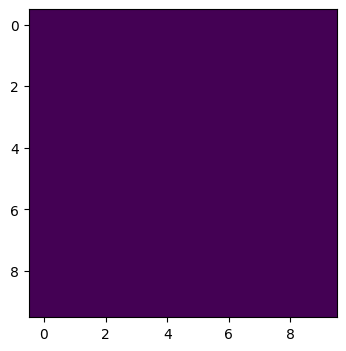

Evaluation 188 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.62it/s]


Completed. Saving
Time (s) to complete simulation 188: 0.9009528160095215


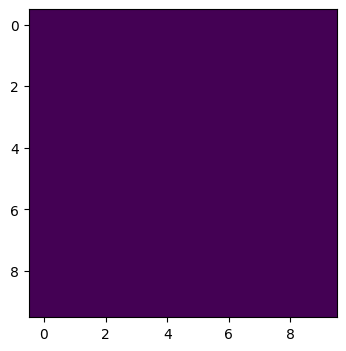

Evaluation 189 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.92it/s]


Completed. Saving
Time (s) to complete simulation 189: 0.9168992042541504


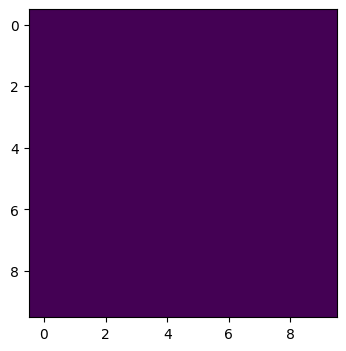

Evaluation 190 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 184.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.25it/s]


Completed. Saving
Time (s) to complete simulation 190: 0.9207179546356201


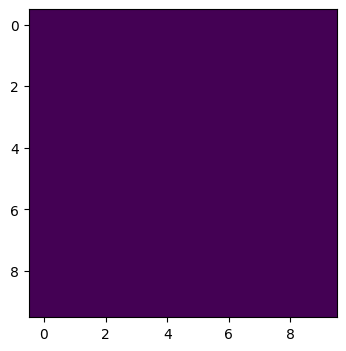

Evaluation 191 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.86it/s]


Completed. Saving
Time (s) to complete simulation 191: 0.9592993259429932


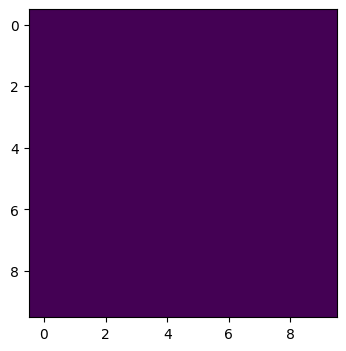

Evaluation 192 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 182.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.72it/s]


Completed. Saving
Time (s) to complete simulation 192: 0.9448573589324951


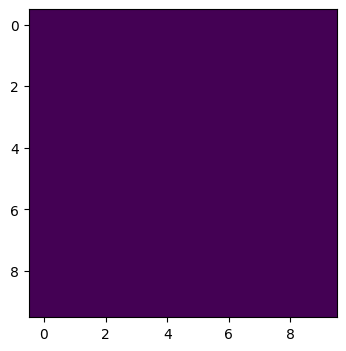

Evaluation 193 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 167.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.97it/s]


Completed. Saving
Time (s) to complete simulation 193: 0.9438402652740479


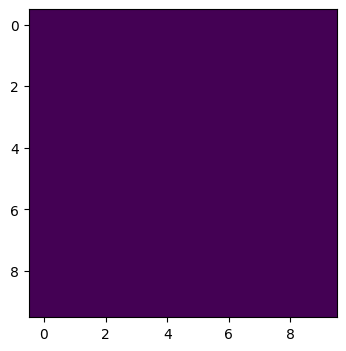

Evaluation 194 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 175.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.96it/s]


Completed. Saving
Time (s) to complete simulation 194: 1.303926944732666


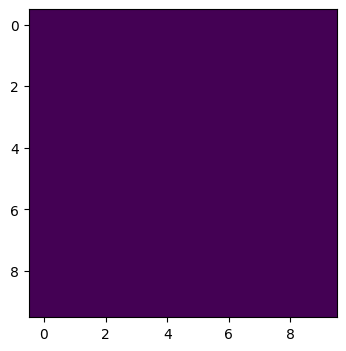

Evaluation 195 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 127.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.25it/s]


Completed. Saving
Time (s) to complete simulation 195: 1.4224634170532227


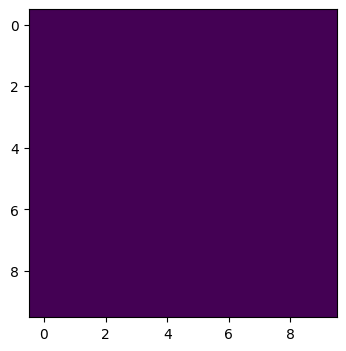

Evaluation 196 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 122.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.05it/s]


Completed. Saving
Time (s) to complete simulation 196: 1.1234004497528076


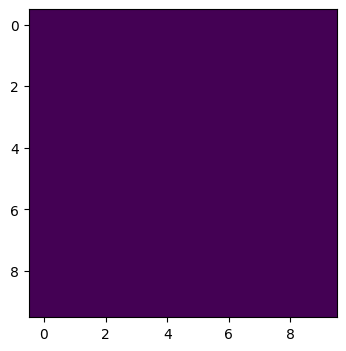

Evaluation 197 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.68it/s]


Completed. Saving
Time (s) to complete simulation 197: 0.9598135948181152


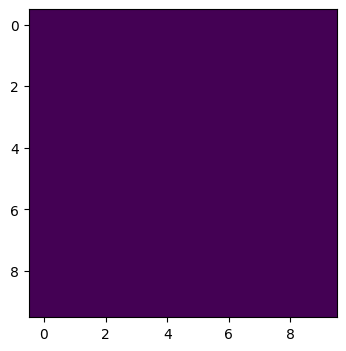

Evaluation 198 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.00it/s]


Completed. Saving
Time (s) to complete simulation 198: 0.935016393661499


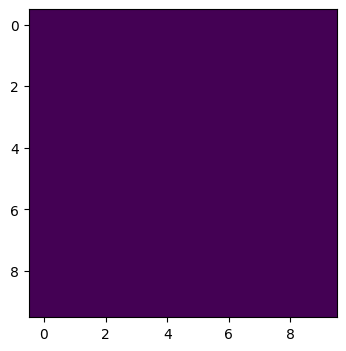

Evaluation 199 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.47it/s]


Completed. Saving
Time (s) to complete simulation 199: 0.9239692687988281


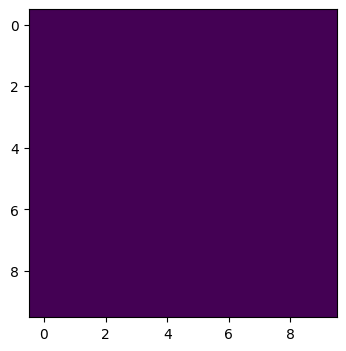

Evaluation 200 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.27it/s]


Completed. Saving
Time (s) to complete simulation 200: 0.9480710029602051


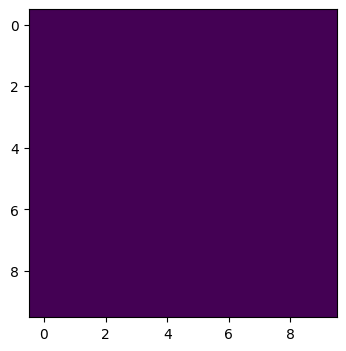

Evaluation 201 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.27it/s]


Completed. Saving
Time (s) to complete simulation 201: 0.9332799911499023


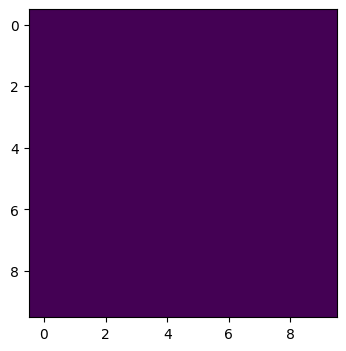

In [23]:
Jx = xs

results_dict = {}
approx_ys = np.zeros(xs.shape[0])
approx_ys1 = np.zeros(xs.shape[0])
approx_ys2 = np.zeros(xs.shape[0])

time_eval = np.zeros(xs.shape[0])

for i in range(0, Jx.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i],0,0],
                      [0,Jx[i],0,Jx[i],0],
                      [0,0,Jx[i],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(N_total))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 10, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(time_eval[i]))
    results_dict[i] = {'sim': sq_sim.results,}

    approx_ys[i] = results_dict[i]['sim']['SpecificHeat']
    approx_ys1[i] = results_dict[i]['sim']['Magnetization']
    approx_ys2[i] = results_dict[i]['sim']['Susceptibility']

    plt.imshow(results_dict[i]['sim']['config'][-1])
    plt.show()

(0.9509529747180084, 0.209114184174733)

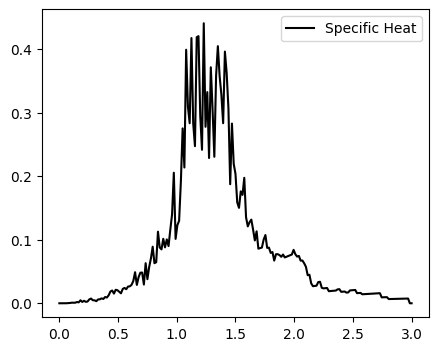

In [24]:
plt.plot(xs, approx_ys, "k", label="Specific Heat")
plt.legend(loc="best")
np.mean(time_eval), np.std(time_eval)

# Symbolic Regression


Here, we explore the symbolic regression over the Ising model predictions.

## Specific Heat

In [25]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys

In [26]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:857: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(


In [27]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.930e+04
Head worker occupation: 2.5%
Progress: 63 / 1500 total iterations (4.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.789e+00  1.594e+01  y = x₀
2           1.190e-02  5.457e+00  y = tanh(square(0.29414))
4           1.104e-02  3.754e-02  y = (tanh(tanh(x₀)) * 0.14661)
5           7.437e-03  3.947e-01  y = square(x₀ / exp(x₀))
6           6.751e-03  9.682e-02  y = square(x₀ / exp(0.90971 * x₀))
7           4.706e-03  3.608e-01  y = (square(tanh(square(x₀))) / exp(x₀))
8           2.066e-03  8.232e-01  y = (0.31564 / (square(3.6 - exp(x₀)) + tanh(1.3975)))
10          1.238e-03  2.560e-01  y = ((0.33986 * x₀) / (square(3.6311 - exp(x₀)) + x₀))
12          1.206e-03  1.335e-02  y = ((0.36094 * (x₀ - 0.07245)) / (square(3.6 - exp(x₀)) + x₀)...
                                  )
-----------------------------------------

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x0   
	1        5.457295                           tanh(square(0.29413608))   
	2        0.037535                      (tanh(tanh(x0)) * 0.14661297)   
	3        0.394733                               square(x0 / exp(x0))   
	4        0.096824                    square(x0 / exp(0.909714 * x0))   
	5        0.360800               (square(tanh(square(x0))) / exp(x0))   
	6        0.901729  (0.32523015 / (square(-3.7337358 + exp(x0)) + ...   
	7        0.004352  (0.32523015 / (square(-3.7337358 + exp(x0)) + ...   
	8  >>>>  0.429063  ((0.33986297 * x0) / (square(3.631127 - exp(x0...   
	9        0.026152  (((x0 + -0.22710289) * 0.4136169) / (square(3....   
	
	       loss  complexity  
	0  2.789404           1  
	1  0.011897           2  
	2  0.011037           4  
	3  0.007437           5  
	4  0.006751           6  
	5  0.004706           7  
	6  0.001910           8  
	7  0.001902           9  
	8  0.001238          10  
	9  0.001175          12  
]

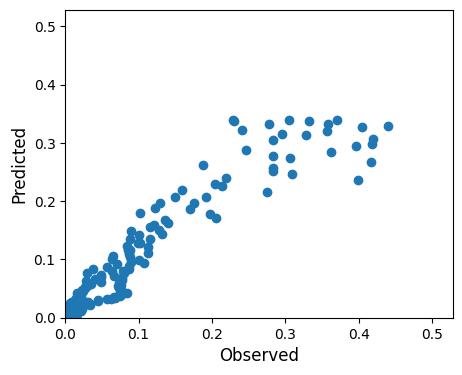

In [28]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

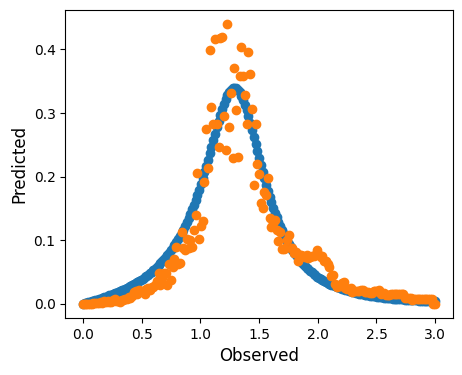

In [29]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [30]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): \frac{0.340 x_{0}}{x_{0} + 13.2 \left(1 - 0.275 e^{x_{0}}\right)^{2}}
R2 score: 0.8959176433746195


## Magnetization

In [31]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys1

In [32]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:857: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(


In [33]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.440e+04
Head worker occupation: 2.5%
Progress: 50 / 1500 total iterations (3.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.006e+00  1.594e+01  y = x₀
2           3.550e-02  3.345e+00  y = (x₀ * 0.39811)
3           1.830e-02  6.626e-01  y = square(tanh(x₀))
4           7.737e-03  8.608e-01  y = tanh(square(x₀ + -0.33266))
6           6.005e-03  1.267e-01  y = tanh(square(x₀ - 0.38385) + 0.080059)
7           5.130e-03  1.576e-01  y = tanh(square(square(x₀ + -0.44295) + 0.31495))
9           5.130e-03  2.980e-08  y = tanh(square(square(x₀ + -0.44295) + tanh(tanh(0.3384))))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 7.850e+04
Head worker occupation: 1.9%
Progress: 108 / 1500 total i

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                                 x0   
	1        3.440173e+00                                  (x0 * 0.43090078)   
	2        5.670948e-01                                   square(tanh(x0))   
	3        8.607684e-01                      tanh(square(x0 + -0.3326633))   
	4        1.267169e-01       tanh(square(x0 + -0.38385728) + 0.080062546)   
	5        1.575661e-01  tanh(square(square(x0 + -0.44294614) + 0.31494...   
	6        2.924261e-08  tanh(square(square(x0 + -0.44295466) + tanh(ta...   
	7  >>>>  3.705981e-01  square(tanh(square(x0 - 0.20489506) / (tanh(x0...   
	
	       loss  complexity  
	0  1.006309           1  
	1  0.032261           2  
	2  0.018298           3  
	3  0.007737           4  
	4  0.006005           6  
	5  0.005130           7  
	6  0.005130           9  
	7  0.003541          10  
]

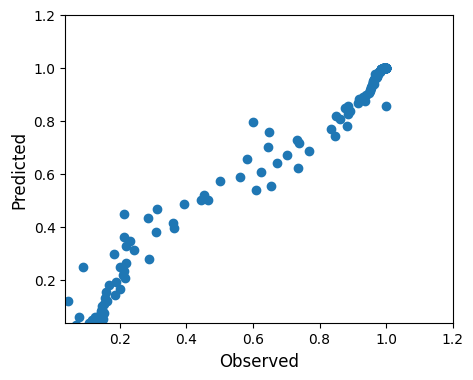

In [34]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

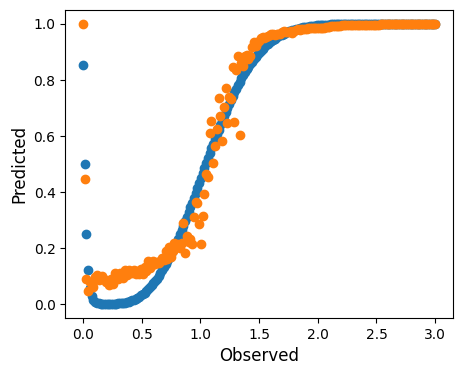

In [35]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [36]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): \tanh^{2}{\left(\frac{\left(x_{0} - 0.205\right)^{2}}{\tanh{\left(x_{0} \right)} + 0.0260} \right)}
R2 score: 0.9760358191396835


## Susceptibility

In [37]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys2

In [38]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:857: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(


In [39]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.200e+05
Head worker occupation: 2.3%
Progress: 77 / 1500 total iterations (5.133%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.808e+00  1.594e+01  y = x₀
2           4.313e-01  1.873e+00  y = tanh(square(0.63762))
4           3.616e-01  8.814e-02  y = tanh(square(2.384 - x₀))
6           2.501e-01  1.843e-01  y = (x₀ / exp(square(x₀ - 0.61422)))
7           1.397e-01  5.826e-01  y = (1.5004 / exp(square(square(x₀) - 1.3217)))
9           1.268e-01  4.852e-02  y = ((1.4805 * x₀) / exp(square(square(x₀) - 1.0644)))
10          1.254e-01  1.076e-02  y = (exp((1.4945 - square(x₀)) * square(x₀)) * square(x₀))
11          1.217e-01  2.991e-02  y = (((1.5828 * x₀) * x₀) / exp(square(square(x₀) - 0.83936)))
12          1.181e-01  3.025e-02  y = (exp((1.5909 - square(x₀)) * square(x₀ * x₀)) * square(x₀)...
                            

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x0   
	1        1.873144                            tanh(square(0.6376243))   
	2        0.088136                       tanh(square(2.3839605 - x0))   
	3        0.184344                 (x0 / exp(square(x0 - 0.6142229)))   
	4  >>>>  0.582577  (1.5004429 / exp(square(square(x0) - 1.3217231)))   
	5        0.048523  ((1.4804853 * x0) / exp(square(square(x0) - 1....   
	6        0.010760  (exp((1.4944794 - square(x0)) * square(x0)) * ...   
	7        0.029913  (((1.5828063 * x0) * x0) / exp(square(square(x...   
	8        0.030253  (exp((1.590892 - square(x0)) * square(x0 * x0)...   
	
	       loss  complexity  
	0  2.807503           1  
	1  0.431344           2  
	2  0.361635           4  
	3  0.250121           6  
	4  0.139682           7  
	5  0.126764           9  
	6  0.125407          10  
	7  0.121711          11  
	8  0.118084          12  
]

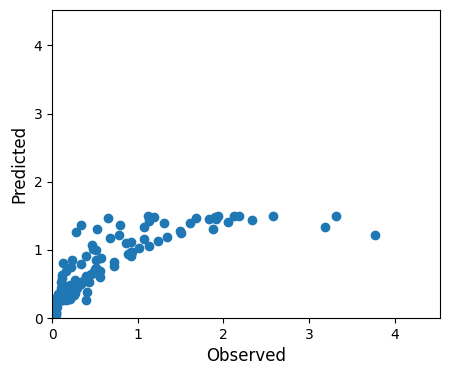

In [40]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

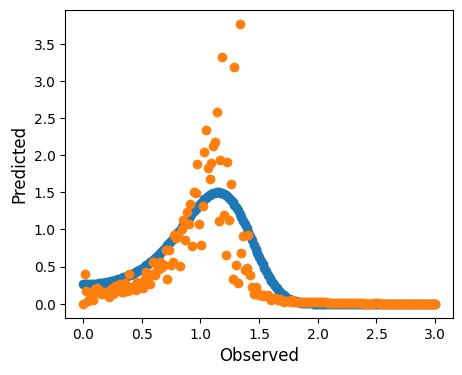

In [41]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [42]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): 1.50 e^{- 1.75 \left(0.757 x_{0}^{2} - 1\right)^{2}}
R2 score: 0.6761700710353653


In [43]:
model.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,2.807503,0.000000,x0,x0,PySRFunction(X=>x0)
1,2,0.431344,1.873144,tanh(square(0.6376243)),0.385551959351056,PySRFunction(X=>0.385551959351056)
2,4,0.361635,0.088136,tanh(square(2.3839605 - x0)),tanh(5.68326766556025*(1 - 0.419470037360099*x...,PySRFunction(X=>tanh(5.68326766556025*(1 - 0.4...
3,6,0.250121,0.184344,(x0 / exp(square(x0 - 0.6142229))),x0*exp(-(x0 - 0.6142229)**2),PySRFunction(X=>x0*exp(-(x0 - 0.6142229)**2))
4,7,0.139682,0.582577,(1.5004429 / exp(square(square(x0) - 1.3217231))),1.5004429*exp(-1.74695195307361*(0.75658812348...,PySRFunction(X=>1.5004429*exp(-1.7469519530736...
5,9,0.126764,0.048523,((1.4804853 * x0) / exp(square(square(x0) - 1....,1.4804853*x0*exp(-1.133034642481*(0.9394602425...,PySRFunction(X=>1.4804853*x0*exp(-1.1330346424...
6,10,0.125407,0.010760,(exp((1.4944794 - square(x0)) * square(x0)) * ...,x0**2*exp(x0**2*(1.4944794 - x0**2)),PySRFunction(X=>x0**2*exp(x0**2*(1.4944794 - x...
7,11,0.121711,0.029913,(((1.5828063 * x0) * x0) / exp(square(square(x...,1.5828063*x0**2*exp(-(x0**2 - 0.8393577)**2),PySRFunction(X=>1.5828063*x0**2*exp(-(x0**2 - ...
8,12,0.118084,0.030253,(exp((1.590892 - square(x0)) * square(x0 * x0)...,x0**2*exp(x0**4*(1.590892 - x0**2)),PySRFunction(X=>x0**2*exp(x0**4*(1.590892 - x0...


In [44]:
model.equations_['equation'][6]

'(exp((1.4944794 - square(x0)) * square(x0)) * square(x0))'